# initializations

In [1]:
import networkx as nx
from graph_embeddings.data_loader import DataLoader
import os
import pickle
import numpy as np
from random import choice
import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import matplotlib.pyplot as plt
from copy import copy
from enum import Enum
from collections import deque
import torch.optim as optim
from random import random
from copy import deepcopy
from tqdm import tqdm
from operator import add


# observing dataset 

In [2]:
data_loader = DataLoader(dataset='MetaQA', reverse_rel=True)

In [3]:
entities_voc, relations_voc = data_loader.load_entity_relations_vocab()
entities_inv_voc = {v: k for k, v in entities_voc.items()}

In [4]:
relations_inv_voc = {v: k for k, v in relations_voc.items()}
relations_voc


{'directed_by': 0,
 'has_imdb_rating': 1,
 'release_year': 2,
 'starred_actors': 3,
 'has_imdb_votes': 4,
 'has_imdb_rating_reverse': 5,
 'in_language': 6,
 'release_year_reverse': 7,
 'has_genre_reverse': 8,
 'directed_by_reverse': 9,
 'has_genre': 10,
 'has_imdb_votes_reverse': 11,
 'written_by': 12,
 'has_tags_reverse': 13,
 'has_tags': 14,
 'written_by_reverse': 15,
 'in_language_reverse': 16,
 'starred_actors_reverse': 17}

In [5]:
#entities_voc

# creating embeddings from KGE

## loading trained kge model

In [6]:
from kg_env import load_kge_model
import torch

model = load_kge_model(
    dataset_name='MetaQA',
    model_name='TuckER',
    ent_vec_dim=200,
    rel_vec_dim=200,
    loss_type='CE',
    device=('cuda' if torch.cuda.is_available() else 'cpu'),
    path='TuckER_MetaQA',
    input_dropout=0.3,
    hidden_dropout1=0.4,
    hidden_dropout2=0.5,
    l3_reg=0.2,
)

operating on cpu
building tucker model for embedding generation


In [14]:
# 'Adrian Moat': 970,
#'Adrian Pasdar': 971,
# 'Adrian Rawlins': 972,
# 'Adrian Shergold': 973

model.E(torch.Tensor([970, 971, 972]).long()).shape


torch.Size([3, 200])

## generating embeddings

In [24]:
from kg_env import generate_entity_embeddings
import pickle

ent_emb_dict = generate_entity_embeddings(model, entities_voc)
rel_emb_dict = generate_entity_embeddings(model, relations_voc)

with open('data/MetaQA/entity_emb.pickle', 'wb') as f:
    pickle.dump(ent_emb_dict, f)
    

with open('data/MetaQA/relation_emb.pickle', 'wb') as f:
    pickle.dump(rel_emb_dict, f)
    

    


## load embeddings

In [6]:
with open('MetaQA/entity_emb.pickle', 'rb') as f:
    ent_emb_dict = pickle.load(f)
    

with open('MetaQA/relation_emb.pickle', 'rb') as f:
    rel_emb_dict = pickle.load(f)
    

In [7]:
ent_emb_dict[list(ent_emb_dict.keys())[0]].shape

(200,)

## generating question embeddings

## analyze qa dataset

In [8]:
def load_raw_qa(path, mode='train_1hop'):
    with open(os.path.join(path, f'qa_{mode}.txt'), 'r') as f:
        text = f.read().strip().split('\n')
    return text

qa_train_raw = load_raw_qa('./data/QA_data/MetaQA/')

In [9]:
import re


def extract_question_entity_target(raw_questions):
    all_questions = []
    all_entities = []
    all_targets = []

    for raw_q in raw_questions:
        question, targets = raw_q.split('\t')
        entity = re.findall('\[.*?\]', question)[0] \
            .replace('[', '') \
            .replace(']', '')

        # todo: should I replace entity with some special token?
        question = question.replace(']', '').replace('[', '')
        targets = targets.strip().split('|')
        all_questions.append(question)
        all_targets.append(targets)
        all_entities.append(entity)

    return all_questions, all_entities, all_targets


qa_train_raw = load_raw_qa('./data/QA_data/MetaQA/', mode='train_3hop')
questions, _, _ = extract_question_entity_target(qa_train_raw)
print(max([len(s) for s in questions]))

151


In [47]:
from typing import List, Dict
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODELS_CACHE_PATH = '.'



def tokenize_sentences(sentences: List[str], tokenizer_path=MODELS_CACHE_PATH, max_len=160):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', cache_dir=MODELS_CACHE_PATH)
    tokenizer_res = tokenizer(
        sentences, return_tensors='pt', max_length=max_len, truncation=True, padding='max_length')
    tokenizer_res.to(device)
    return tokenizer_res

def get_batch_embeddings(tokenizer_results: Dict, batch_size=128):
    i = 0
    embeddings = []
    roberta = RobertaModel.from_pretrained('roberta-base', cache_dir=MODELS_CACHE_PATH).to(device)
    pbar = tqdm(total=len(tokenizer_results['input_ids'])//batch_size)
    while i < len(tokenizer_results['input_ids']):
        model_input = {}
        for key in tokenizer_results:
            model_input[key] = tokenizer_results[key][i:i+batch_size]
        outputs = roberta(**model_input)
        embeddings.append(outputs.pooler_output.detach().cpu().numpy())
        i += batch_size
        pbar.update(1)
    
    return embeddings



In [ ]:
tokenizer_res = tokenize_sentences(questions)
print(tokenizer_res['input_ids'].shape)

In [48]:
embeddings = get_batch_embeddings(tokenizer_res, batch_size=1)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





  0%|                                                                                                                                                                             | 0/14274 [00:00<?, ?it/s]




  0%|                                                                              

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0486,  0.0761, -0.0288,  ..., -0.1312, -0.0418, -0.0443],
         [ 0.0131, -0.1777, -0.0614,  ..., -0.3306,  0.1801,  0.0568],
         [ 0.0847,  0.1649,  0.0865,  ...,  0.2064, -0.0259, -0.0863],
         ...,
         [ 0.0565,  0.0920,  0.0201,  ..., -0.1220, -0.0156, -0.0208],
         [ 0.0565,  0.0920,  0.0201,  ..., -0.1220, -0.0156, -0.0208],
         [ 0.0565,  0.0920,  0.0201,  ..., -0.1220, -0.0156, -0.0208]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-1.1188e-02, -2.0919e-01, -2.2745e-01, -1.1578e-01,  1.6160e-01,
          1.9390e-01,  2.5668e-01, -7.2665e-02, -5.9200e-02, -1.7820e-01,
          2.3287e-01, -1.2546e-03, -8.6979e-02,  8.9313e-02, -1.3310e-01,
          5.0997e-01,  2.2478e-01, -4.6840e-01,  7.0964e-03, -3.6931e-02,
         -2.4895e-01,  5.7112e-02,  4.6074e-01,  2.9635e-01,  1.3442e-01,
          7.6506e-02, -1.2433e-01, -3.5329e-02,  1.8925e-01,  2.2929






  0%|                                                                                                                                                                   | 2/14274 [00:01<3:06:13,  1.28it/s]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0483,  0.0658, -0.0396,  ..., -0.0925, -0.0512, -0.0151],
         [ 0.0408, -0.3234, -0.2024,  ..., -0.2671,  0.1068, -0.0395],
         [ 0.0705, -0.1757, -0.1514,  ..., -0.5613, -0.1411, -0.0526],
         ...,
         [ 0.0405, -0.0021,  0.0159,  ..., -0.0421, -0.0428,  0.0964],
         [ 0.0405, -0.0021,  0.0159,  ..., -0.0421, -0.0428,  0.0964],
         [ 0.0405, -0.0021,  0.0159,  ..., -0.0421, -0.0428,  0.0964]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-3.0601e-03, -2.1779e-01, -2.0223e-01, -9.0303e-02,  1.1932e-01,
          1.8957e-01,  2.5946e-01, -7.7788e-02, -7.1099e-02, -1.6559e-01,
          2.2084e-01, -1.8129e-02, -1.0156e-01,  8.3201e-02, -1.3346e-01,
          4.9150e-01,  2.0551e-01, -4.5526e-01,  2.3696e-02, -3.3467e-02,
         -2.4801e-01,  6.0791e-02,  4.5524e-01,  3.0210e-01,  1.1699e-01,
          7.6753e-02, -1.2701e-01, -1.6016e-02,  1.9760e-01,  2.1011






  0%|                                                                                                                                                                   | 3/14274 [00:02<3:01:31,  1.31it/s]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0443,  0.0958, -0.0258,  ..., -0.1095, -0.0524, -0.0792],
         [ 0.0289, -0.2903, -0.0484,  ..., -0.3300,  0.1950, -0.2918],
         [ 0.3139,  0.2377,  0.0223,  ..., -0.1324,  0.3695, -0.1022],
         ...,
         [-0.0213, -0.0294,  0.0015,  ...,  0.0400, -0.0248, -0.0330],
         [-0.0213, -0.0294,  0.0015,  ...,  0.0400, -0.0248, -0.0330],
         [-0.0213, -0.0294,  0.0015,  ...,  0.0400, -0.0248, -0.0330]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-1.1580e-02, -2.2915e-01, -2.1842e-01, -1.1189e-01,  1.5850e-01,
          2.0361e-01,  2.5357e-01, -1.0500e-01, -8.0442e-02, -1.5308e-01,
          2.3498e-01, -4.6535e-02, -9.5518e-02,  9.9269e-02, -1.4516e-01,
          4.9914e-01,  2.1731e-01, -4.7995e-01,  1.4769e-02, -3.3811e-02,
         -2.4594e-01,  4.8498e-02,  4.6983e-01,  3.0698e-01,  1.1170e-01,
          7.3765e-02, -1.1803e-01, -2.7452e-02,  2.2611e-01,  2.2226






  0%|                                                                                                                                                                   | 4/14274 [00:03<3:00:54,  1.31it/s]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0427,  0.0858, -0.0220,  ..., -0.1157, -0.0512, -0.0309],
         [ 0.0114, -0.2390, -0.0557,  ..., -0.3332,  0.1852,  0.0751],
         [ 0.0879,  0.1554,  0.1251,  ...,  0.1847, -0.0294, -0.0489],
         ...,
         [-0.0561,  0.0998, -0.0271,  ..., -0.2057,  0.0201, -0.1525],
         [-0.0561,  0.0998, -0.0271,  ..., -0.2057,  0.0201, -0.1525],
         [-0.0561,  0.0998, -0.0271,  ..., -0.2057,  0.0201, -0.1525]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-1.3738e-02, -2.0784e-01, -2.1963e-01, -1.1118e-01,  1.5323e-01,
          1.8332e-01,  2.5949e-01, -7.3172e-02, -5.0565e-02, -1.7314e-01,
          2.2505e-01, -3.7901e-05, -8.0733e-02,  7.8247e-02, -1.2294e-01,
          5.1120e-01,  2.2906e-01, -4.6926e-01,  1.0668e-02, -3.9428e-02,
         -2.3985e-01,  7.2482e-02,  4.5569e-01,  2.9660e-01,  1.3645e-01,
          7.0573e-02, -1.2183e-01, -3.9758e-02,  1.9024e-01,  2.2503

In [49]:
embeddings[0].shape

(1, 768)

## gather all questions for embeddings generation

In [10]:
all_questions = []

for ds in ['train', 'dev', 'test']:
    for nhop in ['1', '2', '3']:
        raw = load_raw_qa('./data/QA_data/MetaQA/', mode=f'{ds}_{nhop}hop')
        questions, _, _ = extract_question_entity_target(raw)
        all_questions.extend(questions)

print(len(all_questions))

746105


In [11]:
all_questions[100]

'which movies can be described by robert schwentke'

In [56]:
with open('all-questions.pickle', 'wb') as f:
    pickle.dump(all_questions, f)

## load question embeddings

In [12]:
with open('q-emb-dict.pickle', 'rb') as f:
    question_embs = pickle.load(f)

In [13]:
question_embs['which movies can be described by robert schwentke'].shape

(768,)

In [74]:
np.min(np.array(list(question_embs.values())))

-1.0

# Knowledge graph

In [19]:
graph = data_loader.build_graph()

In [20]:
graph.adj[4]

AtlasView({767: {'relation_id': 0, 'relation_text': 'directed_by'}, 7125: {'relation_id': 10, 'relation_text': 'has_genre'}, 184: {'relation_id': 2, 'relation_text': 'release_year'}})

In [21]:
# same as graph.adj
graph[1024]

AtlasView({1121: {'relation_id': 12, 'relation_text': 'written_by'}, 167: {'relation_id': 2, 'relation_text': 'release_year'}, 15595: {'relation_id': 6, 'relation_text': 'in_language'}, 31150: {'relation_id': 0, 'relation_text': 'directed_by'}, 40514: {'relation_id': 14, 'relation_text': 'has_tags'}})

In [22]:
graph.nodes[1024]

{'entity_text': 'has_tags_reverse'}

In [23]:
for nbr, eattr in graph[5].items():
    print(nbr, eattr)

37824 {'relation_id': 12, 'relation_text': 'written_by'}
165 {'relation_id': 2, 'relation_text': 'release_year'}
28874 {'relation_id': 0, 'relation_text': 'directed_by'}


## moving in graph

In [24]:
def traverse(entity_name, relation):
    entity_id = entities_voc[entity_name]
    neighbors = graph[entity_id]
    for nbr_id, eattr in neighbors.items():
        if eattr['relation_text'] == relation:
            return entities_inv_voc[nbr_id]
        
traverse('After the Rain', 'written_by')

'Akira Kurosawa'

## creating knowledge graph environment

In [69]:
import gym
from gym import spaces

class KGEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, n_relations, observation_space, q_embeddings, ent_embeddings, rel_embeddings,
                 entities_vocab, entities_inv_vocab, rel_inv_voc, rel_voc, mode='train', nhops=[1,2,3]):
        super(KGEnv, self).__init__()
        
        self.entities_vocab = entities_vocab
        self.entities_inv_vocab = entities_inv_vocab
        self.relations_inv_voc = rel_inv_voc
        self.action_space = spaces.Discrete(n_relations)
        self.rel_embeddings = rel_embeddings
        self.observation_space = spaces.Box(low=-3, high=3, shape=(observation_space,))
        self.q_embeddings = q_embeddings
        self.ent_embeddings = ent_embeddings
        self.relations_voc = rel_voc
        self.questions = []
        self.entities = []
        self.targets = []
        self.loop_reward = 0 if mode in ['dev', 'test'] else -1
        
        for nhop in [str(h) for h in nhops]:
            raw = load_raw_qa('./data/QA_data/MetaQA/', mode=f'{mode}_{nhop}hop')
            questions, entities, targets = extract_question_entity_target(raw)
            self.questions.extend(questions)
            self.entities.extend(entities)
            self.targets.extend(targets)
            
        print(f"Total env size in mode {mode}: {len(self.targets)}")

        self.entities_idx = [entities_voc[t] for t in self.entities]
        self.targets_idx = [[entities_voc[t] for t in ts] for ts in self.targets]
        self.env_size = len(self.targets)
        self.goal = None
        self.hops = 0
        self.current_q = self.current_ent = None
        self.ent_hist = []
        self.rel_hist = []
    
    def step(self, action):
        reward = 0
        done = False
        
        self.hops += 1
        next_ent_id = self.traverse(self.current_ent, action)
        if next_ent_id == -1:
            next_ent_id = self.entities_vocab[self.current_ent]
            reward = self.loop_reward 

        #TODO:
        if next_ent_id in self.goal:
            done = True
            reward = 1
            
        if self.hops > 3:
            done = True
            
        e2_emb = self.ent_embeddings[next_ent_id]
        e1_emb = self.ent_embeddings[self.entities_vocab[self.current_ent]]
        r_emb = self.rel_embeddings[action]
        
#         self.rel_hist = r_emb if self.rel_hist is None else (r_emb + self.rel_hist)/2
#         self.ent_hist = (e1_emb + e2_emb)/2
        
        self.rel_hist.append(r_emb)
        self.ent_hist.append(e2_emb)
        
        self.current_ent = self.entities_inv_vocab[next_ent_id]
        next_state = self.build_state_vec(self.current_q, next_ent_id, self.ent_hist, self.rel_hist)
        
        return next_state, reward, done, {}
    
    
    def build_state_vec(self, question: str, entity: int, ent_hist, rel_hist):
        q_emb = self.q_embeddings[question]
        e_emb = self.ent_embeddings[entity]
        
        ent_track = len(ent_hist)
        ent_hist_emb = sum(ent_hist)/ent_track
        
        rel_track = len(rel_hist)
        rel_hist_emb = sum(rel_hist)/rel_track
        
        return np.concatenate([q_emb, e_emb, ent_hist_emb, rel_hist_emb])
        
    def traverse(self, entity_name, relation):
        entity_id = entities_voc[entity_name]
        neighbors = graph[entity_id]
        possible_moves = []
        for nbr_id, eattr in neighbors.items():
            if eattr['relation_id'] == relation:
                possible_moves.append(nbr_id)
        
        if len(possible_moves):
            return choice(possible_moves)
        return -1
        
    
    def reset(self):
        self.hops = 0
        self.rel_hist = [np.zeros(200)]
        self.ent_hist = []
        init_state = np.random.randint(low=0, high=self.env_size-1)
        self.goal = self.targets_idx[init_state]
        self.current_q = self.questions[init_state]
        self.current_ent = self.entities[init_state]
        e_emb = self.ent_embeddings[self.entities_idx[init_state]]
        self.ent_hist.append(e_emb)
        return self.build_state_vec(self.current_q, self.entities_idx[init_state], self.ent_hist, self.rel_hist)
    
    
    def render(self, mode='human', close=False):
        print(self.current_q)
        print(f"current entity: {self.current_ent}")
        entity_id = entities_voc[self.current_ent]
        neighbors = graph[entity_id]
        
        print("available moves:")
        for nbr_id, eattr in neighbors.items():
            print(f"--{eattr['relation_text']}({eattr['relation_id']})--> {self.entities_inv_vocab[nbr_id]}")
    
    
kg_env = KGEnv(len(relations_voc), observation_space=768+200+200+200, q_embeddings=question_embs,
               ent_embeddings=ent_emb_dict, rel_embeddings=rel_emb_dict, entities_vocab=entities_voc, entities_inv_vocab=entities_inv_voc,
                rel_inv_voc=relations_inv_voc, rel_voc=relations_voc)
s = kg_env.reset()
s.shape

Total env size in mode train: 667874


(1368,)

In [371]:
def manual_play_in_env():
    state = kg_env.reset()
    done = False
    
    while not done:
        kg_env.render()        
        action = int(input())
        state, reward, done, _ = kg_env.step(action)
        
manual_play_in_env()

when was the film Be with Me released
current entity: Be with Me
available moves:
--written_by(11)--> Eric Khoo
--written_by(11)--> Theresa Poh Lin Chan
--release_year(16)--> 2005
--has_genre(13)--> Drama
--in_language(8)--> English
16


# RL agent definition

## QActor-critic

In [37]:

class QActorCritic:
    def __init__(self, tau, buffer_size, gamma, actor_lr, critic_lr, state_size, action_size, batch_size,
                 device, warmup_step=1000, verbose=0, critic_warmup=5000, eps=0.5, min_eps=0.05):

        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        
        self.buffer = deque()
        self.action_size = action_size
        self.state_size = state_size
        self.critic_warmup = critic_warmup
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.tau = tau
        self.min_eps = min_eps
        self.eps = eps
        
        self.q = FCNet(state_size, action_size)
        self.q_target = FCNet(state_size, action_size)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.q_target.load_state_dict(self.q.state_dict())
        self.critic_opt = optim.Adam(self.q.parameters(), lr=critic_lr)
        
        self.actor = FCNet(state_size, action_size, last_activation='softmax')
        self.actor_target = FCNet(state_size, action_size, last_activation='softmax')
        self.actor.to(self.device)
        self.actor_target.to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        
        self.update_step = 0
        self.warmup_step = warmup_step
        
        
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
        
    def get_action(self, state, det=False):
        """
        if det=False it will sample based on output probabilities of policy function
        """
#         state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.policy(state), dim=1)
            
            return actions
        
    def get_target_action(self, state, det=False):
        with torch.no_grad():
            if not det:
                dist = Categorical(self.actor_target(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.actor_target(state), dim=1)
            
            return actions
        
    def get_single_action(self, state, det=False):
        if self.update_step < self.critic_warmup:
            return np.random.randint(self.action_size)
        
        if (random() < self.eps and not det):
            return np.random.randint(self.action_size)
        
        state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                action = dist.sample()
            else:
                action = torch.argmax(self.policy(state), dim=1)
            
        return action.cpu().numpy()[0]
    
    def policy(self, state):
        return self.actor(state)
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q.parameters()
            targ_params = self.q_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
                
            params = self.actor.parameters()
            targ_params = self.actor_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
            
        
    def update_critic(self, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
                        
            next_actions = self.get_target_action(batch_next_states, det=False)
            
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*self.get_q_val(self.q_target, batch_next_states, next_actions).squeeze())
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        self.critic_opt.zero_grad()
        loss.backward()
        self.critic_opt.step()
        
        self.synchronize()
        
        return loss.detach().cpu().numpy()
    

    def update_actor(self, batch_states):
#         with torch.no_grad():
#             q_vals = self.get_q_val(self.q_target, batch_states, batch_actions).squeeze()
        dist = self.policy(batch_states)
        actions = dist.sample()
        with torch.no_grad():
            q_vals = self.get_q_val(self.q, batch_states, actions).squeeze()
            
        action_probs = self.policy(batch_states)
        action_logprobs = torch.clip(dist.log_prob(actions), min=-10, max=10)
        
        loss = -torch.mean(q_vals*action_logprobs)
        
        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        
        return loss.detach().cpu().numpy()
    
    
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
    
        self.add_to_buffer([state, action, reward, next_state, done])
        
        #TODO: warmup. should be configurable.
        if len(self.buffer) < self.warmup_step:
            return None, None         


        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()

        if self.update_step < self.critic_warmup:
            critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
            return None, critic_loss

        if done:
            self.eps = max(self.min_eps, self.eps*0.999)
        
        critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
        actor_loss = self.update_actor(batch_states)
        
        return actor_loss, critic_loss



## Double DQN

In [70]:
class FCNet(nn.Module):

    def __init__(self, input_size, output_size, last_activation=None):
        super(FCNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, output_size)
        self.last_activation = last_activation
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        if self.last_activation == 'softmax':
            x = F.softmax(x, dim=1)
        
        return x
    
class DoubleDQN:
    def __init__(self, buffer_size, gamma, lr, eps, state_size, action_size, batch_size,
                 device, tau=0.99, eps_decay=0.999, min_eps=0.05, warmup_step=1000):
        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        self.lr = lr
        self.eps = eps
        
        #self.buffer = deque()
        self.buffer = [None]*self.max_buffer_size
        self.buf_idx = 0
        
        self.action_size = action_size
        self.device = device
        self.q = FCNet(state_size, action_size)
        self.q_target = FCNet(state_size, action_size)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.batch_size = batch_size
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.update_step = 0
        self.tau = tau
        self.min_eps = min_eps
        self.eps_decay = eps_decay
        self.warmup_steps = warmup_step
        
       
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
#         if len(self.buffer) >= self.max_buffer_size:
#             self.buffer.pop()
#         self.buffer.appendleft(experience)
        self.buffer[self.buf_idx%self.max_buffer_size] = experience
        self.buf_idx += 1
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        #idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        idxs = np.random.randint(0, min(self.max_buffer_size, self.buf_idx), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q.parameters()
            targ_params = self.q_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
        
    def get_action(self, state, det=False):
        state = torch.from_numpy(state).float().to(self.device)
        with torch.no_grad():
            act = np.argmax(self.get_q_val(self.q, state).cpu().numpy())
        if det:
            return act
        if random() < self.eps:
            return np.random.randint(0, self.action_size)
        else:
            #TODO: sample from q dist?
            return act
        
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
        
        self.add_to_buffer([state, action, reward, next_state, done])
        
        if self.buf_idx < self.warmup_steps:
            return
        
        if done:
            self.eps = max(self.min_eps, self.eps * self.eps_decay)
        
        
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()
        
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
            
            random_vals = torch.rand(size=(self.batch_size, ), device=self.device)
            rand_mask = random_vals < self.eps
            det_mask = random_vals >= self.eps
            random_actions = torch.randint(low=0, high=self.action_size, size=(self.batch_size, ), device=self.device)
            random_actions[det_mask] = 0
            
            next_actions = torch.argmax(self.get_q_val(self.q_target, batch_next_states), dim=1)
            next_actions[rand_mask] = 0
            
            next_actions = next_actions + random_actions
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*self.get_q_val(self.q, batch_next_states, next_actions).squeeze())
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.synchronize()

        


## training

In [ ]:
def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")


def evaluate_agent(env, agent, k=10):
    returns = []
    for _ in range(k):
        state = env.reset()
        done = False
        ret = 0
        while not done:
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            ret += reward
        returns.append(ret)
    return returns
            
def train_and_evaluate(env, agent, epochs, eval_env, eval_step=100, eval_it=50):
    
    returns = []
    epsilons = []
    eval_rets = []
    for i in tqdm(range(1, epochs+1)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_action(state)
            next_state, r, done, _ = env.step(a)
            agent.update(state, a, r, next_state, done)
            ret += r
            state = next_state
        done = False
        epsilons.append(agent.eps)
        returns.append(ret)
        
        
        if i%eval_step == 0:
            avg_ret = np.mean(evaluate_agent(eval_env, agent, k=eval_it))
            log(f"epoch:{i} dev average return={avg_ret} current_eps:{agent.eps} buffer_size:{agent.buf_idx}")
            
            avg_ret = np.mean(evaluate_agent(env, agent, k=eval_it))
            log(f"epoch:{i} train average return={avg_ret} current_eps:{agent.eps} buffer_size:{agent.buf_idx}")
            
            eval_rets.append(avg_ret)
            
    return returns, epsilons, eval_rets



env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='train'
)


eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='dev'
)

ddqn = DoubleDQN(
    buffer_size=300000,
    gamma=0.99,
    lr=3e-5,
    eps=0.8,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=256,
    eps_decay=0.9999,
    warmup_step=50000,
    min_eps=0.05,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)


returns, epsilons, eval_rets = train_and_evaluate(env, ddqn, epochs=800000, eval_env=eval_env, eval_step=1000, eval_it=100)

Total env size in mode train: 667874
Total env size in mode dev: 39138


  0%|          | 975/800000 [00:01<21:02, 633.06it/s]

epoch:1000 dev average return=0.08 current_eps:0.8 buffer_size:3721
epoch:1000 train average return=-2.96 current_eps:0.8 buffer_size:3721


  0%|          | 2018/800000 [00:03<39:16, 338.57it/s]

epoch:2000 dev average return=0.08 current_eps:0.8 buffer_size:7514
epoch:2000 train average return=-3.11 current_eps:0.8 buffer_size:7514


  0%|          | 3002/800000 [00:05<39:33, 335.80it/s]

epoch:3000 dev average return=0.07 current_eps:0.8 buffer_size:11288
epoch:3000 train average return=-3.1 current_eps:0.8 buffer_size:11288


  1%|          | 4023/800000 [00:07<40:37, 326.52it/s]

epoch:4000 dev average return=0.07 current_eps:0.8 buffer_size:15032
epoch:4000 train average return=-2.93 current_eps:0.8 buffer_size:15032


  1%|          | 5009/800000 [00:09<39:58, 331.43it/s]

epoch:5000 dev average return=0.12 current_eps:0.8 buffer_size:18788
epoch:5000 train average return=-3.22 current_eps:0.8 buffer_size:18788


  1%|          | 5985/800000 [00:10<21:23, 618.42it/s]

epoch:6000 dev average return=0.05 current_eps:0.8 buffer_size:22555
epoch:6000 train average return=-3.11 current_eps:0.8 buffer_size:22555


  1%|          | 7019/800000 [00:13<39:42, 332.79it/s]

epoch:7000 dev average return=0.1 current_eps:0.8 buffer_size:26279
epoch:7000 train average return=-2.86 current_eps:0.8 buffer_size:26279


  1%|          | 7996/800000 [00:14<20:07, 655.79it/s]

epoch:8000 dev average return=0.07 current_eps:0.8 buffer_size:30029
epoch:8000 train average return=-2.99 current_eps:0.8 buffer_size:30029


  1%|          | 9021/800000 [00:16<40:01, 329.39it/s]

epoch:9000 dev average return=0.07 current_eps:0.8 buffer_size:33804
epoch:9000 train average return=-2.87 current_eps:0.8 buffer_size:33804


  1%|▏         | 10005/800000 [00:18<39:39, 332.06it/s]

epoch:10000 dev average return=0.09 current_eps:0.8 buffer_size:37560
epoch:10000 train average return=-2.84 current_eps:0.8 buffer_size:37560


  1%|▏         | 11026/800000 [00:20<39:38, 331.67it/s]

epoch:11000 dev average return=0.09 current_eps:0.8 buffer_size:41361
epoch:11000 train average return=-2.92 current_eps:0.8 buffer_size:41361


  2%|▏         | 12009/800000 [00:22<40:35, 323.60it/s]

epoch:12000 dev average return=0.07 current_eps:0.8 buffer_size:45093
epoch:12000 train average return=-3.08 current_eps:0.8 buffer_size:45093


  2%|▏         | 12986/800000 [00:24<20:56, 626.56it/s]

epoch:13000 dev average return=0.04 current_eps:0.8 buffer_size:48838
epoch:13000 train average return=-3.16 current_eps:0.8 buffer_size:48838


  2%|▏         | 13998/800000 [00:44<5:31:06, 39.56it/s] 

epoch:14000 dev average return=0.13 current_eps:0.7465094436266348 buffer_size:52595
epoch:14000 train average return=-2.41 current_eps:0.7465094436266348 buffer_size:52595


  2%|▏         | 14998/800000 [01:09<5:26:18, 40.10it/s] 

epoch:15000 dev average return=0.16 current_eps:0.6754662999454752 buffer_size:56116
epoch:15000 train average return=-2.12 current_eps:0.6754662999454752 buffer_size:56116


  2%|▏         | 15999/800000 [01:35<6:51:56, 31.72it/s] 

epoch:16000 dev average return=0.2 current_eps:0.6111841266809553 buffer_size:59461
epoch:16000 train average return=-1.38 current_eps:0.6111841266809553 buffer_size:59461


  2%|▏         | 17001/800000 [01:58<7:14:16, 30.05it/s] 

epoch:17000 dev average return=0.16 current_eps:0.5530195018417877 buffer_size:62615
epoch:17000 train average return=-1.26 current_eps:0.5530195018417877 buffer_size:62615


  2%|▏         | 17998/800000 [02:19<3:59:32, 54.41it/s]

epoch:18000 dev average return=0.26 current_eps:0.5003902360458173 buffer_size:65679
epoch:18000 train average return=-0.86 current_eps:0.5003902360458173 buffer_size:65679


  2%|▏         | 19000/800000 [02:41<6:28:32, 33.50it/s] 

epoch:19000 dev average return=0.31 current_eps:0.4527695451897866 buffer_size:68605
epoch:19000 train average return=-0.74 current_eps:0.4527695451897866 buffer_size:68605


  2%|▎         | 20000/800000 [03:03<7:33:02, 28.69it/s]

epoch:20000 dev average return=0.29 current_eps:0.40968077768926664 buffer_size:71420
epoch:20000 train average return=-0.68 current_eps:0.40968077768926664 buffer_size:71420


  3%|▎         | 21001/800000 [03:22<5:42:23, 37.92it/s]

epoch:21000 dev average return=0.32 current_eps:0.370692643511899 buffer_size:74161
epoch:21000 train average return=-0.71 current_eps:0.370692643511899 buffer_size:74161


  3%|▎         | 22000/800000 [03:40<5:45:14, 37.56it/s]

epoch:22000 dev average return=0.35 current_eps:0.33541489724974133 buffer_size:76769
epoch:22000 train average return=-0.36 current_eps:0.33541489724974133 buffer_size:76769


  3%|▎         | 23001/800000 [03:58<5:25:31, 39.78it/s] 

epoch:23000 dev average return=0.36 current_eps:0.3034944320211294 buffer_size:79304
epoch:23000 train average return=-0.39 current_eps:0.3034944320211294 buffer_size:79304


  3%|▎         | 24001/800000 [04:16<5:08:01, 41.99it/s] 

epoch:24000 dev average return=0.48 current_eps:0.27461174510458947 buffer_size:81756
epoch:24000 train average return=0.18 current_eps:0.27461174510458947 buffer_size:81756


  3%|▎         | 24999/800000 [04:35<2:57:04, 72.95it/s] 

epoch:25000 dev average return=0.39 current_eps:0.2484777399281507 buffer_size:84174
epoch:25000 train average return=-0.09 current_eps:0.2484777399281507 buffer_size:84174


  3%|▎         | 26001/800000 [04:53<6:54:41, 31.11it/s]

epoch:26000 dev average return=0.35 current_eps:0.22483083240407906 buffer_size:86487
epoch:26000 train average return=0.17 current_eps:0.22483083240407906 buffer_size:86487


  3%|▎         | 27002/800000 [05:11<5:27:05, 39.39it/s]

epoch:27000 dev average return=0.45 current_eps:0.20343433264536218 buffer_size:88783
epoch:27000 train average return=0.28 current_eps:0.20343433264536218 buffer_size:88783


  4%|▎         | 28000/800000 [05:30<5:17:54, 40.47it/s]

epoch:28000 dev average return=0.5 current_eps:0.18407407585665692 buffer_size:91086
epoch:28000 train average return=0.33 current_eps:0.18407407585665692 buffer_size:91086


  4%|▎         | 29001/800000 [05:47<5:48:13, 36.90it/s]

epoch:29000 dev average return=0.42 current_eps:0.16655627868649603 buffer_size:93330
epoch:29000 train average return=0.12 current_eps:0.16655627868649603 buffer_size:93330


  4%|▍         | 30005/800000 [06:04<6:09:12, 34.76it/s]

epoch:30000 dev average return=0.52 current_eps:0.15070559958424723 buffer_size:95583
epoch:30000 train average return=0.29 current_eps:0.15070559958424723 buffer_size:95583


  4%|▍         | 31001/800000 [06:20<5:57:29, 35.85it/s]

epoch:31000 dev average return=0.54 current_eps:0.13636338374729134 buffer_size:97801
epoch:31000 train average return=0.2 current_eps:0.13636338374729134 buffer_size:97801


  4%|▍         | 32001/800000 [06:36<5:48:08, 36.77it/s]

epoch:32000 dev average return=0.61 current_eps:0.12338607509149727 buffer_size:99927
epoch:32000 train average return=0.34 current_eps:0.12338607509149727 buffer_size:99927


  4%|▍         | 33000/800000 [06:51<4:25:43, 48.11it/s]

epoch:33000 dev average return=0.54 current_eps:0.11164377934987277 buffer_size:102022
epoch:33000 train average return=0.37 current_eps:0.11164377934987277 buffer_size:102022


  4%|▍         | 34003/800000 [07:06<5:53:40, 36.10it/s]

epoch:34000 dev average return=0.53 current_eps:0.10101896391695851 buffer_size:104106
epoch:34000 train average return=0.37 current_eps:0.10101896391695851 buffer_size:104106


  4%|▍         | 35000/800000 [07:21<3:36:38, 58.85it/s]

epoch:35000 dev average return=0.55 current_eps:0.091405281425269 buffer_size:106186
epoch:35000 train average return=0.52 current_eps:0.091405281425269 buffer_size:106186


  5%|▍         | 36003/800000 [07:37<5:04:30, 41.82it/s]

epoch:36000 dev average return=0.49 current_eps:0.08270650527856034 buffer_size:108245
epoch:36000 train average return=0.44 current_eps:0.08270650527856034 buffer_size:108245


  5%|▍         | 37004/800000 [07:52<4:42:33, 45.00it/s]

epoch:37000 dev average return=0.56 current_eps:0.07483556648731582 buffer_size:110281
epoch:37000 train average return=0.55 current_eps:0.07483556648731582 buffer_size:110281


  5%|▍         | 38004/800000 [08:08<6:31:19, 32.45it/s]

epoch:38000 dev average return=0.52 current_eps:0.06771368216581165 buffer_size:112350
epoch:38000 train average return=0.57 current_eps:0.06771368216581165 buffer_size:112350


  5%|▍         | 39004/800000 [08:23<6:31:08, 32.43it/s]

epoch:39000 dev average return=0.59 current_eps:0.061269566967595716 buffer_size:114380
epoch:39000 train average return=0.65 current_eps:0.061269566967595716 buffer_size:114380


  5%|▌         | 40000/800000 [08:39<4:28:19, 47.21it/s]

epoch:40000 dev average return=0.57 current_eps:0.05543871956636933 buffer_size:116340
epoch:40000 train average return=0.49 current_eps:0.05543871956636933 buffer_size:116340


  5%|▌         | 41006/800000 [08:53<4:21:56, 48.29it/s]

epoch:41000 dev average return=0.61 current_eps:0.050162777040419264 buffer_size:118264
epoch:41000 train average return=0.54 current_eps:0.050162777040419264 buffer_size:118264


  5%|▌         | 42004/800000 [09:08<5:45:35, 36.56it/s]

epoch:42000 dev average return=0.63 current_eps:0.05 buffer_size:120263
epoch:42000 train average return=0.43 current_eps:0.05 buffer_size:120263


  5%|▌         | 43000/800000 [09:23<4:30:01, 46.72it/s] 

epoch:43000 dev average return=0.56 current_eps:0.05 buffer_size:122274
epoch:43000 train average return=0.61 current_eps:0.05 buffer_size:122274


  6%|▌         | 44001/800000 [09:37<6:22:41, 32.93it/s]

epoch:44000 dev average return=0.65 current_eps:0.05 buffer_size:124230
epoch:44000 train average return=0.65 current_eps:0.05 buffer_size:124230


  6%|▌         | 45007/800000 [09:52<4:07:25, 50.86it/s]

epoch:45000 dev average return=0.64 current_eps:0.05 buffer_size:126175
epoch:45000 train average return=0.54 current_eps:0.05 buffer_size:126175


  6%|▌         | 46001/800000 [10:06<4:07:47, 50.71it/s]

epoch:46000 dev average return=0.52 current_eps:0.05 buffer_size:128187
epoch:46000 train average return=0.65 current_eps:0.05 buffer_size:128187


  6%|▌         | 47006/800000 [10:21<3:32:57, 58.93it/s]

epoch:47000 dev average return=0.61 current_eps:0.05 buffer_size:130161
epoch:47000 train average return=0.47 current_eps:0.05 buffer_size:130161


  6%|▌         | 48000/800000 [10:37<3:45:44, 55.52it/s]

epoch:48000 dev average return=0.63 current_eps:0.05 buffer_size:132113
epoch:48000 train average return=0.56 current_eps:0.05 buffer_size:132113


  6%|▌         | 49004/800000 [10:50<3:59:13, 52.32it/s] 

epoch:49000 dev average return=0.78 current_eps:0.05 buffer_size:134014
epoch:49000 train average return=0.53 current_eps:0.05 buffer_size:134014


  6%|▋         | 50002/800000 [11:06<6:01:41, 34.56it/s]

epoch:50000 dev average return=0.67 current_eps:0.05 buffer_size:136011
epoch:50000 train average return=0.53 current_eps:0.05 buffer_size:136011


  6%|▋         | 50995/800000 [11:19<2:44:14, 76.01it/s] 

epoch:51000 dev average return=0.65 current_eps:0.05 buffer_size:137913
epoch:51000 train average return=0.62 current_eps:0.05 buffer_size:137913


  7%|▋         | 52002/800000 [11:38<4:25:47, 46.91it/s] 

epoch:52000 dev average return=0.62 current_eps:0.05 buffer_size:139872
epoch:52000 train average return=0.48 current_eps:0.05 buffer_size:139872


  7%|▋         | 53004/800000 [11:52<4:41:11, 44.27it/s] 

epoch:53000 dev average return=0.66 current_eps:0.05 buffer_size:141799
epoch:53000 train average return=0.54 current_eps:0.05 buffer_size:141799


  7%|▋         | 53999/800000 [12:07<2:34:48, 80.31it/s] 

epoch:54000 dev average return=0.64 current_eps:0.05 buffer_size:143716
epoch:54000 train average return=0.72 current_eps:0.05 buffer_size:143716


  7%|▋         | 55009/800000 [12:25<3:43:02, 55.67it/s] 

epoch:55000 dev average return=0.58 current_eps:0.05 buffer_size:145669
epoch:55000 train average return=0.63 current_eps:0.05 buffer_size:145669


  7%|▋         | 56004/800000 [12:41<6:16:21, 32.95it/s]

epoch:56000 dev average return=0.59 current_eps:0.05 buffer_size:147585
epoch:56000 train average return=0.68 current_eps:0.05 buffer_size:147585


  7%|▋         | 57003/800000 [12:57<4:36:00, 44.87it/s]

epoch:57000 dev average return=0.56 current_eps:0.05 buffer_size:149583
epoch:57000 train average return=0.57 current_eps:0.05 buffer_size:149583


  7%|▋         | 58003/800000 [13:13<4:17:08, 48.09it/s] 

epoch:58000 dev average return=0.55 current_eps:0.05 buffer_size:151550
epoch:58000 train average return=0.55 current_eps:0.05 buffer_size:151550


  7%|▋         | 59003/800000 [13:27<5:31:37, 37.24it/s] 

epoch:59000 dev average return=0.62 current_eps:0.05 buffer_size:153500
epoch:59000 train average return=0.47 current_eps:0.05 buffer_size:153500


  8%|▊         | 60000/800000 [13:42<4:06:50, 49.96it/s]

epoch:60000 dev average return=0.65 current_eps:0.05 buffer_size:155403
epoch:60000 train average return=0.56 current_eps:0.05 buffer_size:155403


  8%|▊         | 61010/800000 [13:56<3:56:21, 52.11it/s]

epoch:61000 dev average return=0.62 current_eps:0.05 buffer_size:157346
epoch:61000 train average return=0.66 current_eps:0.05 buffer_size:157346


  8%|▊         | 62003/800000 [14:10<3:12:13, 63.99it/s]

epoch:62000 dev average return=0.68 current_eps:0.05 buffer_size:159273
epoch:62000 train average return=0.65 current_eps:0.05 buffer_size:159273


  8%|▊         | 63006/800000 [14:25<3:35:08, 57.09it/s]

epoch:63000 dev average return=0.59 current_eps:0.05 buffer_size:161242
epoch:63000 train average return=0.61 current_eps:0.05 buffer_size:161242


  8%|▊         | 64004/800000 [14:40<3:29:16, 58.61it/s]

epoch:64000 dev average return=0.63 current_eps:0.05 buffer_size:163195
epoch:64000 train average return=0.63 current_eps:0.05 buffer_size:163195


  8%|▊         | 65006/800000 [14:55<4:13:08, 48.39it/s]

epoch:65000 dev average return=0.65 current_eps:0.05 buffer_size:165173
epoch:65000 train average return=0.63 current_eps:0.05 buffer_size:165173


  8%|▊         | 66001/800000 [15:09<4:20:26, 46.97it/s] 

epoch:66000 dev average return=0.67 current_eps:0.05 buffer_size:167068
epoch:66000 train average return=0.57 current_eps:0.05 buffer_size:167068


  8%|▊         | 67011/800000 [15:23<3:25:48, 59.36it/s] 

epoch:67000 dev average return=0.72 current_eps:0.05 buffer_size:169010
epoch:67000 train average return=0.62 current_eps:0.05 buffer_size:169010


  8%|▊         | 68000/800000 [15:37<6:28:23, 31.41it/s] 

epoch:68000 dev average return=0.61 current_eps:0.05 buffer_size:170859
epoch:68000 train average return=0.55 current_eps:0.05 buffer_size:170859


  9%|▊         | 69002/800000 [15:51<3:55:06, 51.82it/s] 

epoch:69000 dev average return=0.64 current_eps:0.05 buffer_size:172716
epoch:69000 train average return=0.66 current_eps:0.05 buffer_size:172716


  9%|▉         | 70000/800000 [16:06<5:22:24, 37.74it/s]

epoch:70000 dev average return=0.67 current_eps:0.05 buffer_size:174673
epoch:70000 train average return=0.6 current_eps:0.05 buffer_size:174673


  9%|▉         | 71005/800000 [16:22<4:37:56, 43.71it/s] 

epoch:71000 dev average return=0.54 current_eps:0.05 buffer_size:176569
epoch:71000 train average return=0.64 current_eps:0.05 buffer_size:176569


  9%|▉         | 72001/800000 [16:38<5:37:56, 35.90it/s]

epoch:72000 dev average return=0.67 current_eps:0.05 buffer_size:178479
epoch:72000 train average return=0.69 current_eps:0.05 buffer_size:178479


  9%|▉         | 73003/800000 [16:53<3:45:37, 53.70it/s]

epoch:73000 dev average return=0.6 current_eps:0.05 buffer_size:180393
epoch:73000 train average return=0.59 current_eps:0.05 buffer_size:180393


  9%|▉         | 74006/800000 [17:07<4:58:58, 40.47it/s]

epoch:74000 dev average return=0.63 current_eps:0.05 buffer_size:182249
epoch:74000 train average return=0.63 current_eps:0.05 buffer_size:182249


  9%|▉         | 75014/800000 [17:22<3:15:25, 61.83it/s]

epoch:75000 dev average return=0.6 current_eps:0.05 buffer_size:184193
epoch:75000 train average return=0.55 current_eps:0.05 buffer_size:184193


 10%|▉         | 76005/800000 [17:37<5:14:36, 38.35it/s] 

epoch:76000 dev average return=0.65 current_eps:0.05 buffer_size:186047
epoch:76000 train average return=0.54 current_eps:0.05 buffer_size:186047


 10%|▉         | 76997/800000 [17:52<3:54:17, 51.43it/s] 

epoch:77000 dev average return=0.56 current_eps:0.05 buffer_size:187981
epoch:77000 train average return=0.59 current_eps:0.05 buffer_size:187981


 10%|▉         | 78000/800000 [18:09<4:25:38, 45.30it/s]

epoch:78000 dev average return=0.63 current_eps:0.05 buffer_size:189914
epoch:78000 train average return=0.48 current_eps:0.05 buffer_size:189914


 10%|▉         | 79002/800000 [18:25<4:38:18, 43.18it/s]

epoch:79000 dev average return=0.6 current_eps:0.05 buffer_size:191822
epoch:79000 train average return=0.63 current_eps:0.05 buffer_size:191822


 10%|█         | 80000/800000 [18:40<3:37:51, 55.08it/s]

epoch:80000 dev average return=0.65 current_eps:0.05 buffer_size:193694
epoch:80000 train average return=0.63 current_eps:0.05 buffer_size:193694


 10%|█         | 81003/800000 [18:54<3:56:28, 50.68it/s] 

epoch:81000 dev average return=0.55 current_eps:0.05 buffer_size:195613
epoch:81000 train average return=0.68 current_eps:0.05 buffer_size:195613


 10%|█         | 81999/800000 [19:10<2:12:54, 90.03it/s] 

epoch:82000 dev average return=0.63 current_eps:0.05 buffer_size:197485
epoch:82000 train average return=0.48 current_eps:0.05 buffer_size:197485


 10%|█         | 83011/800000 [19:24<2:46:00, 71.98it/s] 

epoch:83000 dev average return=0.64 current_eps:0.05 buffer_size:199315
epoch:83000 train average return=0.65 current_eps:0.05 buffer_size:199315


 11%|█         | 84002/800000 [19:38<4:07:12, 48.27it/s] 

epoch:84000 dev average return=0.63 current_eps:0.05 buffer_size:201233
epoch:84000 train average return=0.61 current_eps:0.05 buffer_size:201233


 11%|█         | 85002/800000 [19:55<4:39:16, 42.67it/s]

epoch:85000 dev average return=0.64 current_eps:0.05 buffer_size:203136
epoch:85000 train average return=0.6 current_eps:0.05 buffer_size:203136


 11%|█         | 85997/800000 [20:11<2:34:22, 77.08it/s]

epoch:86000 dev average return=0.65 current_eps:0.05 buffer_size:205045
epoch:86000 train average return=0.59 current_eps:0.05 buffer_size:205045


 11%|█         | 87004/800000 [20:26<4:15:46, 46.46it/s]

epoch:87000 dev average return=0.65 current_eps:0.05 buffer_size:206865
epoch:87000 train average return=0.7 current_eps:0.05 buffer_size:206865


 11%|█         | 87999/800000 [20:40<2:44:26, 72.16it/s] 

epoch:88000 dev average return=0.68 current_eps:0.05 buffer_size:208775
epoch:88000 train average return=0.67 current_eps:0.05 buffer_size:208775


 11%|█         | 89001/800000 [20:56<4:46:17, 41.39it/s]

epoch:89000 dev average return=0.63 current_eps:0.05 buffer_size:210762
epoch:89000 train average return=0.6 current_eps:0.05 buffer_size:210762


 11%|█▏        | 90001/800000 [21:10<4:24:27, 44.75it/s]

epoch:90000 dev average return=0.66 current_eps:0.05 buffer_size:212619
epoch:90000 train average return=0.72 current_eps:0.05 buffer_size:212619


 11%|█▏        | 91003/800000 [21:26<3:56:34, 49.95it/s]

epoch:91000 dev average return=0.65 current_eps:0.05 buffer_size:214520
epoch:91000 train average return=0.62 current_eps:0.05 buffer_size:214520


 12%|█▏        | 92005/800000 [21:40<3:54:00, 50.42it/s]

epoch:92000 dev average return=0.68 current_eps:0.05 buffer_size:216424
epoch:92000 train average return=0.59 current_eps:0.05 buffer_size:216424


 12%|█▏        | 93005/800000 [21:55<4:01:01, 48.89it/s]

epoch:93000 dev average return=0.68 current_eps:0.05 buffer_size:218294
epoch:93000 train average return=0.73 current_eps:0.05 buffer_size:218294


 12%|█▏        | 94009/800000 [22:10<3:31:50, 55.54it/s]

epoch:94000 dev average return=0.56 current_eps:0.05 buffer_size:220173
epoch:94000 train average return=0.64 current_eps:0.05 buffer_size:220173


 12%|█▏        | 94998/800000 [22:23<2:46:46, 70.46it/s] 

epoch:95000 dev average return=0.52 current_eps:0.05 buffer_size:222086
epoch:95000 train average return=0.71 current_eps:0.05 buffer_size:222086


 12%|█▏        | 96001/800000 [22:39<3:43:34, 52.48it/s]

epoch:96000 dev average return=0.66 current_eps:0.05 buffer_size:223995
epoch:96000 train average return=0.62 current_eps:0.05 buffer_size:223995


 12%|█▏        | 97000/800000 [22:52<3:27:32, 56.45it/s] 

epoch:97000 dev average return=0.63 current_eps:0.05 buffer_size:225881
epoch:97000 train average return=0.62 current_eps:0.05 buffer_size:225881


 12%|█▏        | 98000/800000 [23:06<4:07:22, 47.30it/s] 

epoch:98000 dev average return=0.68 current_eps:0.05 buffer_size:227798
epoch:98000 train average return=0.52 current_eps:0.05 buffer_size:227798


 12%|█▏        | 99004/800000 [23:21<4:21:38, 44.65it/s]

epoch:99000 dev average return=0.7 current_eps:0.05 buffer_size:229716
epoch:99000 train average return=0.73 current_eps:0.05 buffer_size:229716


 13%|█▎        | 100012/800000 [23:36<2:55:05, 66.63it/s]

epoch:100000 dev average return=0.66 current_eps:0.05 buffer_size:231679
epoch:100000 train average return=0.74 current_eps:0.05 buffer_size:231679


 13%|█▎        | 101005/800000 [23:50<3:53:33, 49.88it/s]

epoch:101000 dev average return=0.66 current_eps:0.05 buffer_size:233530
epoch:101000 train average return=0.67 current_eps:0.05 buffer_size:233530


 13%|█▎        | 102005/800000 [24:05<4:38:58, 41.70it/s] 

epoch:102000 dev average return=0.6 current_eps:0.05 buffer_size:235351
epoch:102000 train average return=0.55 current_eps:0.05 buffer_size:235351


 13%|█▎        | 103006/800000 [24:19<3:56:58, 49.02it/s]

epoch:103000 dev average return=0.59 current_eps:0.05 buffer_size:237283
epoch:103000 train average return=0.64 current_eps:0.05 buffer_size:237283


 13%|█▎        | 104004/800000 [24:33<3:41:32, 52.36it/s] 

epoch:104000 dev average return=0.64 current_eps:0.05 buffer_size:239167
epoch:104000 train average return=0.57 current_eps:0.05 buffer_size:239167


 13%|█▎        | 105001/800000 [24:47<3:01:25, 63.85it/s]

epoch:105000 dev average return=0.61 current_eps:0.05 buffer_size:241052
epoch:105000 train average return=0.68 current_eps:0.05 buffer_size:241052


 13%|█▎        | 106008/800000 [25:01<3:57:00, 48.80it/s] 

epoch:106000 dev average return=0.68 current_eps:0.05 buffer_size:242969
epoch:106000 train average return=0.56 current_eps:0.05 buffer_size:242969


 13%|█▎        | 107004/800000 [25:16<3:31:41, 54.56it/s] 

epoch:107000 dev average return=0.58 current_eps:0.05 buffer_size:244857
epoch:107000 train average return=0.75 current_eps:0.05 buffer_size:244857


 14%|█▎        | 108000/800000 [25:30<4:53:50, 39.25it/s] 

epoch:108000 dev average return=0.7 current_eps:0.05 buffer_size:246712
epoch:108000 train average return=0.59 current_eps:0.05 buffer_size:246712


 14%|█▎        | 109001/800000 [25:44<5:13:30, 36.73it/s]

epoch:109000 dev average return=0.67 current_eps:0.05 buffer_size:248627
epoch:109000 train average return=0.44 current_eps:0.05 buffer_size:248627


 14%|█▍        | 110012/800000 [25:57<3:05:21, 62.04it/s] 

epoch:110000 dev average return=0.7 current_eps:0.05 buffer_size:250444
epoch:110000 train average return=0.55 current_eps:0.05 buffer_size:250444


 14%|█▍        | 111004/800000 [26:11<3:57:39, 48.32it/s]

epoch:111000 dev average return=0.65 current_eps:0.05 buffer_size:252293
epoch:111000 train average return=0.82 current_eps:0.05 buffer_size:252293


 14%|█▍        | 112001/800000 [26:26<4:07:04, 46.41it/s]

epoch:112000 dev average return=0.72 current_eps:0.05 buffer_size:254123
epoch:112000 train average return=0.59 current_eps:0.05 buffer_size:254123


 14%|█▍        | 113006/800000 [26:39<3:27:10, 55.27it/s]

epoch:113000 dev average return=0.72 current_eps:0.05 buffer_size:255991
epoch:113000 train average return=0.71 current_eps:0.05 buffer_size:255991


 14%|█▍        | 114005/800000 [26:53<3:24:28, 55.92it/s]

epoch:114000 dev average return=0.6 current_eps:0.05 buffer_size:257815
epoch:114000 train average return=0.75 current_eps:0.05 buffer_size:257815


 14%|█▍        | 115004/800000 [27:07<3:28:25, 54.78it/s] 

epoch:115000 dev average return=0.58 current_eps:0.05 buffer_size:259647
epoch:115000 train average return=0.74 current_eps:0.05 buffer_size:259647


 14%|█▍        | 115993/800000 [27:22<2:31:03, 75.47it/s]

epoch:116000 dev average return=0.63 current_eps:0.05 buffer_size:261531
epoch:116000 train average return=0.51 current_eps:0.05 buffer_size:261531


 15%|█▍        | 117004/800000 [27:39<5:08:14, 36.93it/s]

epoch:117000 dev average return=0.59 current_eps:0.05 buffer_size:263367
epoch:117000 train average return=0.69 current_eps:0.05 buffer_size:263367


 15%|█▍        | 118005/800000 [27:55<5:16:47, 35.88it/s]

epoch:118000 dev average return=0.63 current_eps:0.05 buffer_size:265251
epoch:118000 train average return=0.51 current_eps:0.05 buffer_size:265251


 15%|█▍        | 119007/800000 [28:12<3:58:43, 47.55it/s]

epoch:119000 dev average return=0.59 current_eps:0.05 buffer_size:267122
epoch:119000 train average return=0.65 current_eps:0.05 buffer_size:267122


 15%|█▌        | 120012/800000 [28:28<3:08:49, 60.02it/s]

epoch:120000 dev average return=0.66 current_eps:0.05 buffer_size:269034
epoch:120000 train average return=0.74 current_eps:0.05 buffer_size:269034


 15%|█▌        | 121007/800000 [28:43<4:11:05, 45.07it/s]

epoch:121000 dev average return=0.64 current_eps:0.05 buffer_size:270914
epoch:121000 train average return=0.62 current_eps:0.05 buffer_size:270914


 15%|█▌        | 122003/800000 [28:58<5:16:47, 35.67it/s]

epoch:122000 dev average return=0.66 current_eps:0.05 buffer_size:272811
epoch:122000 train average return=0.6 current_eps:0.05 buffer_size:272811


 15%|█▌        | 123005/800000 [29:14<4:58:52, 37.75it/s]

epoch:123000 dev average return=0.63 current_eps:0.05 buffer_size:274725
epoch:123000 train average return=0.72 current_eps:0.05 buffer_size:274725


 16%|█▌        | 124004/800000 [29:30<4:30:25, 41.66it/s]

epoch:124000 dev average return=0.62 current_eps:0.05 buffer_size:276550
epoch:124000 train average return=0.7 current_eps:0.05 buffer_size:276550


 16%|█▌        | 125004/800000 [29:47<5:22:31, 34.88it/s]

epoch:125000 dev average return=0.71 current_eps:0.05 buffer_size:278461
epoch:125000 train average return=0.63 current_eps:0.05 buffer_size:278461


 16%|█▌        | 126003/800000 [30:03<3:57:33, 47.29it/s]

epoch:126000 dev average return=0.51 current_eps:0.05 buffer_size:280357
epoch:126000 train average return=0.6 current_eps:0.05 buffer_size:280357


 16%|█▌        | 127008/800000 [30:18<2:51:54, 65.25it/s]

epoch:127000 dev average return=0.69 current_eps:0.05 buffer_size:282195
epoch:127000 train average return=0.65 current_eps:0.05 buffer_size:282195


 16%|█▌        | 127994/800000 [30:33<2:09:03, 86.78it/s]

epoch:128000 dev average return=0.64 current_eps:0.05 buffer_size:284056
epoch:128000 train average return=0.69 current_eps:0.05 buffer_size:284056


 16%|█▌        | 129005/800000 [30:49<4:34:33, 40.73it/s]

epoch:129000 dev average return=0.64 current_eps:0.05 buffer_size:285916
epoch:129000 train average return=0.76 current_eps:0.05 buffer_size:285916


 16%|█▋        | 130009/800000 [31:05<3:33:02, 52.41it/s]

epoch:130000 dev average return=0.59 current_eps:0.05 buffer_size:287811
epoch:130000 train average return=0.66 current_eps:0.05 buffer_size:287811


 16%|█▋        | 131000/800000 [31:20<2:51:37, 64.97it/s]

epoch:131000 dev average return=0.74 current_eps:0.05 buffer_size:289653
epoch:131000 train average return=0.6 current_eps:0.05 buffer_size:289653


 16%|█▋        | 132000/800000 [31:35<3:04:52, 60.22it/s] 

epoch:132000 dev average return=0.59 current_eps:0.05 buffer_size:291544
epoch:132000 train average return=0.62 current_eps:0.05 buffer_size:291544


 17%|█▋        | 133006/800000 [31:51<3:51:11, 48.08it/s] 

epoch:133000 dev average return=0.61 current_eps:0.05 buffer_size:293406
epoch:133000 train average return=0.63 current_eps:0.05 buffer_size:293406


 17%|█▋        | 134004/800000 [32:05<3:58:50, 46.47it/s] 

epoch:134000 dev average return=0.7 current_eps:0.05 buffer_size:295218
epoch:134000 train average return=0.58 current_eps:0.05 buffer_size:295218


 17%|█▋        | 135005/800000 [32:20<3:33:35, 51.89it/s]

epoch:135000 dev average return=0.6 current_eps:0.05 buffer_size:297138
epoch:135000 train average return=0.55 current_eps:0.05 buffer_size:297138


 17%|█▋        | 136008/800000 [32:35<3:38:39, 50.61it/s]

epoch:136000 dev average return=0.62 current_eps:0.05 buffer_size:298993
epoch:136000 train average return=0.64 current_eps:0.05 buffer_size:298993


 17%|█▋        | 136999/800000 [32:51<2:54:33, 63.30it/s]

epoch:137000 dev average return=0.7 current_eps:0.05 buffer_size:300838
epoch:137000 train average return=0.71 current_eps:0.05 buffer_size:300838


 17%|█▋        | 137999/800000 [33:07<3:09:42, 58.16it/s]

epoch:138000 dev average return=0.69 current_eps:0.05 buffer_size:302736
epoch:138000 train average return=0.73 current_eps:0.05 buffer_size:302736


 17%|█▋        | 139008/800000 [33:23<4:19:52, 42.39it/s]

epoch:139000 dev average return=0.71 current_eps:0.05 buffer_size:304578
epoch:139000 train average return=0.72 current_eps:0.05 buffer_size:304578


 18%|█▊        | 140003/800000 [33:39<4:22:13, 41.95it/s]

epoch:140000 dev average return=0.62 current_eps:0.05 buffer_size:306428
epoch:140000 train average return=0.56 current_eps:0.05 buffer_size:306428


 18%|█▊        | 141007/800000 [33:55<3:30:38, 52.14it/s]

epoch:141000 dev average return=0.65 current_eps:0.05 buffer_size:308337
epoch:141000 train average return=0.69 current_eps:0.05 buffer_size:308337


 18%|█▊        | 142006/800000 [34:10<4:01:12, 45.46it/s]

epoch:142000 dev average return=0.69 current_eps:0.05 buffer_size:310154
epoch:142000 train average return=0.72 current_eps:0.05 buffer_size:310154


 18%|█▊        | 143000/800000 [34:24<3:59:56, 45.64it/s]

epoch:143000 dev average return=0.51 current_eps:0.05 buffer_size:311962
epoch:143000 train average return=0.68 current_eps:0.05 buffer_size:311962


 18%|█▊        | 144000/800000 [34:40<4:15:18, 42.82it/s]

epoch:144000 dev average return=0.69 current_eps:0.05 buffer_size:313864
epoch:144000 train average return=0.71 current_eps:0.05 buffer_size:313864


 18%|█▊        | 145008/800000 [34:55<3:06:19, 58.59it/s]

epoch:145000 dev average return=0.6 current_eps:0.05 buffer_size:315773
epoch:145000 train average return=0.73 current_eps:0.05 buffer_size:315773


 18%|█▊        | 146007/800000 [35:10<3:28:19, 52.32it/s] 

epoch:146000 dev average return=0.59 current_eps:0.05 buffer_size:317636
epoch:146000 train average return=0.67 current_eps:0.05 buffer_size:317636


 18%|█▊        | 147004/800000 [35:25<3:59:27, 45.45it/s]

epoch:147000 dev average return=0.65 current_eps:0.05 buffer_size:319500
epoch:147000 train average return=0.68 current_eps:0.05 buffer_size:319500


 19%|█▊        | 148001/800000 [35:41<4:05:27, 44.27it/s]

epoch:148000 dev average return=0.58 current_eps:0.05 buffer_size:321377
epoch:148000 train average return=0.71 current_eps:0.05 buffer_size:321377


 19%|█▊        | 149005/800000 [35:55<3:05:31, 58.48it/s] 

epoch:149000 dev average return=0.65 current_eps:0.05 buffer_size:323181
epoch:149000 train average return=0.66 current_eps:0.05 buffer_size:323181


 19%|█▉        | 150004/800000 [36:10<3:26:14, 52.53it/s]

epoch:150000 dev average return=0.59 current_eps:0.05 buffer_size:325057
epoch:150000 train average return=0.6 current_eps:0.05 buffer_size:325057


 19%|█▉        | 151006/800000 [36:25<2:59:58, 60.10it/s]

epoch:151000 dev average return=0.63 current_eps:0.05 buffer_size:326903
epoch:151000 train average return=0.73 current_eps:0.05 buffer_size:326903


 19%|█▉        | 152003/800000 [36:39<2:56:08, 61.31it/s]

epoch:152000 dev average return=0.71 current_eps:0.05 buffer_size:328768
epoch:152000 train average return=0.64 current_eps:0.05 buffer_size:328768


 19%|█▉        | 153009/800000 [36:53<3:11:39, 56.26it/s]

epoch:153000 dev average return=0.66 current_eps:0.05 buffer_size:330594
epoch:153000 train average return=0.73 current_eps:0.05 buffer_size:330594


 19%|█▉        | 154009/800000 [37:06<3:15:21, 55.11it/s] 

epoch:154000 dev average return=0.6 current_eps:0.05 buffer_size:332376
epoch:154000 train average return=0.64 current_eps:0.05 buffer_size:332376


 19%|█▉        | 154998/800000 [37:21<1:53:26, 94.77it/s]

epoch:155000 dev average return=0.64 current_eps:0.05 buffer_size:334250
epoch:155000 train average return=0.67 current_eps:0.05 buffer_size:334250


 20%|█▉        | 156000/800000 [37:35<2:53:42, 61.79it/s] 

epoch:156000 dev average return=0.66 current_eps:0.05 buffer_size:336040
epoch:156000 train average return=0.71 current_eps:0.05 buffer_size:336040


 20%|█▉        | 156994/800000 [37:50<2:22:28, 75.22it/s]

epoch:157000 dev average return=0.65 current_eps:0.05 buffer_size:337907
epoch:157000 train average return=0.64 current_eps:0.05 buffer_size:337907


 20%|█▉        | 158008/800000 [38:06<2:56:53, 60.49it/s]

epoch:158000 dev average return=0.64 current_eps:0.05 buffer_size:339797
epoch:158000 train average return=0.71 current_eps:0.05 buffer_size:339797


 20%|█▉        | 159002/800000 [38:20<3:43:17, 47.85it/s] 

epoch:159000 dev average return=0.67 current_eps:0.05 buffer_size:341633
epoch:159000 train average return=0.63 current_eps:0.05 buffer_size:341633


 20%|██        | 160000/800000 [38:35<4:32:49, 39.10it/s] 

epoch:160000 dev average return=0.67 current_eps:0.05 buffer_size:343472
epoch:160000 train average return=0.64 current_eps:0.05 buffer_size:343472


 20%|██        | 161011/800000 [38:50<2:23:06, 74.42it/s] 

epoch:161000 dev average return=0.7 current_eps:0.05 buffer_size:345327
epoch:161000 train average return=0.66 current_eps:0.05 buffer_size:345327


 20%|██        | 162010/800000 [39:04<2:41:18, 65.92it/s]

epoch:162000 dev average return=0.69 current_eps:0.05 buffer_size:347232
epoch:162000 train average return=0.67 current_eps:0.05 buffer_size:347232


 20%|██        | 163007/800000 [39:19<3:08:15, 56.39it/s]

epoch:163000 dev average return=0.68 current_eps:0.05 buffer_size:349097
epoch:163000 train average return=0.59 current_eps:0.05 buffer_size:349097


 21%|██        | 164004/800000 [39:33<3:07:07, 56.65it/s]

epoch:164000 dev average return=0.69 current_eps:0.05 buffer_size:350916
epoch:164000 train average return=0.69 current_eps:0.05 buffer_size:350916


 21%|██        | 165000/800000 [39:50<3:38:38, 48.41it/s]

epoch:165000 dev average return=0.69 current_eps:0.05 buffer_size:352875
epoch:165000 train average return=0.6 current_eps:0.05 buffer_size:352875


 21%|██        | 166004/800000 [40:06<3:44:50, 46.99it/s] 

epoch:166000 dev average return=0.7 current_eps:0.05 buffer_size:354685
epoch:166000 train average return=0.67 current_eps:0.05 buffer_size:354685


 21%|██        | 167000/800000 [40:21<3:54:36, 44.97it/s]

epoch:167000 dev average return=0.72 current_eps:0.05 buffer_size:356489
epoch:167000 train average return=0.71 current_eps:0.05 buffer_size:356489


 21%|██        | 168005/800000 [40:36<3:12:46, 54.64it/s]

epoch:168000 dev average return=0.68 current_eps:0.05 buffer_size:358340
epoch:168000 train average return=0.71 current_eps:0.05 buffer_size:358340


 21%|██        | 169004/800000 [40:50<4:34:15, 38.35it/s]

epoch:169000 dev average return=0.6 current_eps:0.05 buffer_size:360171
epoch:169000 train average return=0.66 current_eps:0.05 buffer_size:360171


 21%|██▏       | 170009/800000 [41:04<2:40:59, 65.22it/s] 

epoch:170000 dev average return=0.66 current_eps:0.05 buffer_size:361999
epoch:170000 train average return=0.64 current_eps:0.05 buffer_size:361999


 21%|██▏       | 171000/800000 [41:18<3:11:41, 54.69it/s]

epoch:171000 dev average return=0.66 current_eps:0.05 buffer_size:363863
epoch:171000 train average return=0.64 current_eps:0.05 buffer_size:363863


 22%|██▏       | 172002/800000 [41:32<3:50:24, 45.43it/s]

epoch:172000 dev average return=0.57 current_eps:0.05 buffer_size:365679
epoch:172000 train average return=0.71 current_eps:0.05 buffer_size:365679


 22%|██▏       | 173002/800000 [41:47<7:00:59, 24.82it/s]

epoch:173000 dev average return=0.6 current_eps:0.05 buffer_size:367565
epoch:173000 train average return=0.59 current_eps:0.05 buffer_size:367565


 22%|██▏       | 174008/800000 [42:01<3:12:54, 54.09it/s] 

epoch:174000 dev average return=0.68 current_eps:0.05 buffer_size:369377
epoch:174000 train average return=0.56 current_eps:0.05 buffer_size:369377


 22%|██▏       | 175008/800000 [42:15<3:13:29, 53.84it/s]

epoch:175000 dev average return=0.65 current_eps:0.05 buffer_size:371232
epoch:175000 train average return=0.69 current_eps:0.05 buffer_size:371232


 22%|██▏       | 176004/800000 [42:30<3:10:22, 54.63it/s] 

epoch:176000 dev average return=0.67 current_eps:0.05 buffer_size:373036
epoch:176000 train average return=0.52 current_eps:0.05 buffer_size:373036


 22%|██▏       | 177005/800000 [42:43<4:08:43, 41.75it/s] 

epoch:177000 dev average return=0.61 current_eps:0.05 buffer_size:374820
epoch:177000 train average return=0.7 current_eps:0.05 buffer_size:374820


 22%|██▏       | 178004/800000 [42:58<5:19:14, 32.47it/s]

epoch:178000 dev average return=0.68 current_eps:0.05 buffer_size:376691
epoch:178000 train average return=0.68 current_eps:0.05 buffer_size:376691


 22%|██▏       | 179003/800000 [43:14<3:22:22, 51.14it/s]

epoch:179000 dev average return=0.73 current_eps:0.05 buffer_size:378624
epoch:179000 train average return=0.66 current_eps:0.05 buffer_size:378624


 22%|██▎       | 180000/800000 [43:29<4:27:23, 38.64it/s]

epoch:180000 dev average return=0.6 current_eps:0.05 buffer_size:380541
epoch:180000 train average return=0.69 current_eps:0.05 buffer_size:380541


 23%|██▎       | 181003/800000 [43:43<2:47:49, 61.47it/s] 

epoch:181000 dev average return=0.68 current_eps:0.05 buffer_size:382360
epoch:181000 train average return=0.67 current_eps:0.05 buffer_size:382360


 23%|██▎       | 182006/800000 [43:58<3:10:42, 54.01it/s]

epoch:182000 dev average return=0.66 current_eps:0.05 buffer_size:384247
epoch:182000 train average return=0.78 current_eps:0.05 buffer_size:384247


 23%|██▎       | 183006/800000 [44:13<3:06:52, 55.03it/s] 

epoch:183000 dev average return=0.64 current_eps:0.05 buffer_size:386050
epoch:183000 train average return=0.79 current_eps:0.05 buffer_size:386050


 23%|██▎       | 184004/800000 [44:27<4:09:32, 41.14it/s]

epoch:184000 dev average return=0.72 current_eps:0.05 buffer_size:387934
epoch:184000 train average return=0.66 current_eps:0.05 buffer_size:387934


 23%|██▎       | 185001/800000 [44:42<3:43:57, 45.77it/s]

epoch:185000 dev average return=0.65 current_eps:0.05 buffer_size:389762
epoch:185000 train average return=0.69 current_eps:0.05 buffer_size:389762


 23%|██▎       | 186009/800000 [44:56<2:41:33, 63.34it/s] 

epoch:186000 dev average return=0.67 current_eps:0.05 buffer_size:391536
epoch:186000 train average return=0.69 current_eps:0.05 buffer_size:391536


 23%|██▎       | 187000/800000 [45:11<2:54:16, 58.62it/s]

epoch:187000 dev average return=0.64 current_eps:0.05 buffer_size:393386
epoch:187000 train average return=0.7 current_eps:0.05 buffer_size:393386


 24%|██▎       | 188004/800000 [45:24<2:58:27, 57.15it/s]

epoch:188000 dev average return=0.66 current_eps:0.05 buffer_size:395229
epoch:188000 train average return=0.66 current_eps:0.05 buffer_size:395229


 24%|██▎       | 189002/800000 [45:40<3:47:50, 44.69it/s] 

epoch:189000 dev average return=0.65 current_eps:0.05 buffer_size:396982
epoch:189000 train average return=0.73 current_eps:0.05 buffer_size:396982


 24%|██▍       | 190004/800000 [45:54<3:00:08, 56.44it/s]

epoch:190000 dev average return=0.65 current_eps:0.05 buffer_size:398864
epoch:190000 train average return=0.63 current_eps:0.05 buffer_size:398864


 24%|██▍       | 191009/800000 [46:08<3:20:25, 50.64it/s]

epoch:191000 dev average return=0.73 current_eps:0.05 buffer_size:400665
epoch:191000 train average return=0.65 current_eps:0.05 buffer_size:400665


 24%|██▍       | 192001/800000 [46:22<3:34:43, 47.19it/s] 

epoch:192000 dev average return=0.64 current_eps:0.05 buffer_size:402505
epoch:192000 train average return=0.73 current_eps:0.05 buffer_size:402505


 24%|██▍       | 192996/800000 [46:36<1:51:40, 90.59it/s]

epoch:193000 dev average return=0.67 current_eps:0.05 buffer_size:404381
epoch:193000 train average return=0.83 current_eps:0.05 buffer_size:404381


 24%|██▍       | 194003/800000 [46:51<3:35:08, 46.94it/s]

epoch:194000 dev average return=0.74 current_eps:0.05 buffer_size:406221
epoch:194000 train average return=0.64 current_eps:0.05 buffer_size:406221


 24%|██▍       | 195009/800000 [47:05<2:36:44, 64.33it/s] 

epoch:195000 dev average return=0.66 current_eps:0.05 buffer_size:408057
epoch:195000 train average return=0.58 current_eps:0.05 buffer_size:408057


 25%|██▍       | 196002/800000 [47:18<3:27:39, 48.48it/s] 

epoch:196000 dev average return=0.66 current_eps:0.05 buffer_size:409863
epoch:196000 train average return=0.71 current_eps:0.05 buffer_size:409863


 25%|██▍       | 197005/800000 [47:32<3:24:06, 49.24it/s]

epoch:197000 dev average return=0.62 current_eps:0.05 buffer_size:411754
epoch:197000 train average return=0.71 current_eps:0.05 buffer_size:411754


 25%|██▍       | 197995/800000 [47:46<1:50:32, 90.77it/s] 

epoch:198000 dev average return=0.67 current_eps:0.05 buffer_size:413604
epoch:198000 train average return=0.75 current_eps:0.05 buffer_size:413604


 25%|██▍       | 199004/800000 [48:02<3:43:27, 44.83it/s]

epoch:199000 dev average return=0.69 current_eps:0.05 buffer_size:415490
epoch:199000 train average return=0.59 current_eps:0.05 buffer_size:415490


 25%|██▌       | 200003/800000 [48:16<5:14:08, 31.83it/s]

epoch:200000 dev average return=0.67 current_eps:0.05 buffer_size:417328
epoch:200000 train average return=0.53 current_eps:0.05 buffer_size:417328


 25%|██▌       | 201003/800000 [48:30<3:52:43, 42.90it/s] 

epoch:201000 dev average return=0.63 current_eps:0.05 buffer_size:419159
epoch:201000 train average return=0.66 current_eps:0.05 buffer_size:419159


 25%|██▌       | 202009/800000 [48:44<3:13:59, 51.38it/s]

epoch:202000 dev average return=0.68 current_eps:0.05 buffer_size:421019
epoch:202000 train average return=0.71 current_eps:0.05 buffer_size:421019


 25%|██▌       | 203003/800000 [48:57<3:12:35, 51.66it/s] 

epoch:203000 dev average return=0.65 current_eps:0.05 buffer_size:422823
epoch:203000 train average return=0.52 current_eps:0.05 buffer_size:422823


 26%|██▌       | 204008/800000 [49:12<3:05:49, 53.45it/s]

epoch:204000 dev average return=0.66 current_eps:0.05 buffer_size:424634
epoch:204000 train average return=0.64 current_eps:0.05 buffer_size:424634


 26%|██▌       | 205006/800000 [49:26<3:13:21, 51.29it/s] 

epoch:205000 dev average return=0.6 current_eps:0.05 buffer_size:426476
epoch:205000 train average return=0.68 current_eps:0.05 buffer_size:426476


 26%|██▌       | 206005/800000 [49:40<3:13:26, 51.18it/s]

epoch:206000 dev average return=0.77 current_eps:0.05 buffer_size:428321
epoch:206000 train average return=0.64 current_eps:0.05 buffer_size:428321


 26%|██▌       | 207010/800000 [49:54<3:01:24, 54.48it/s]

epoch:207000 dev average return=0.72 current_eps:0.05 buffer_size:430189
epoch:207000 train average return=0.71 current_eps:0.05 buffer_size:430189


 26%|██▌       | 208009/800000 [50:08<2:46:30, 59.25it/s]

epoch:208000 dev average return=0.59 current_eps:0.05 buffer_size:432038
epoch:208000 train average return=0.69 current_eps:0.05 buffer_size:432038


 26%|██▌       | 209008/800000 [50:23<3:21:08, 48.97it/s] 

epoch:209000 dev average return=0.7 current_eps:0.05 buffer_size:433872
epoch:209000 train average return=0.57 current_eps:0.05 buffer_size:433872


 26%|██▋       | 210007/800000 [50:37<3:46:40, 43.38it/s]

epoch:210000 dev average return=0.67 current_eps:0.05 buffer_size:435733
epoch:210000 train average return=0.68 current_eps:0.05 buffer_size:435733


 26%|██▋       | 211004/800000 [50:50<3:34:08, 45.84it/s] 

epoch:211000 dev average return=0.72 current_eps:0.05 buffer_size:437477
epoch:211000 train average return=0.69 current_eps:0.05 buffer_size:437477


 27%|██▋       | 212006/800000 [51:05<3:15:48, 50.05it/s] 

epoch:212000 dev average return=0.65 current_eps:0.05 buffer_size:439306
epoch:212000 train average return=0.61 current_eps:0.05 buffer_size:439306


 27%|██▋       | 213013/800000 [51:19<2:27:37, 66.27it/s] 

epoch:213000 dev average return=0.59 current_eps:0.05 buffer_size:441088
epoch:213000 train average return=0.56 current_eps:0.05 buffer_size:441088


 27%|██▋       | 214002/800000 [51:33<3:37:11, 44.97it/s] 

epoch:214000 dev average return=0.71 current_eps:0.05 buffer_size:442867
epoch:214000 train average return=0.6 current_eps:0.05 buffer_size:442867


 27%|██▋       | 215000/800000 [51:47<2:28:25, 65.69it/s] 

epoch:215000 dev average return=0.66 current_eps:0.05 buffer_size:444592
epoch:215000 train average return=0.69 current_eps:0.05 buffer_size:444592


 27%|██▋       | 216002/800000 [52:01<5:06:28, 31.76it/s] 

epoch:216000 dev average return=0.72 current_eps:0.05 buffer_size:446394
epoch:216000 train average return=0.6 current_eps:0.05 buffer_size:446394


 27%|██▋       | 217000/800000 [52:16<2:46:24, 58.39it/s] 

epoch:217000 dev average return=0.59 current_eps:0.05 buffer_size:448182
epoch:217000 train average return=0.64 current_eps:0.05 buffer_size:448182


 27%|██▋       | 217999/800000 [52:30<2:04:36, 77.85it/s] 

epoch:218000 dev average return=0.66 current_eps:0.05 buffer_size:450004
epoch:218000 train average return=0.66 current_eps:0.05 buffer_size:450004


 27%|██▋       | 219009/800000 [52:43<2:39:22, 60.76it/s] 

epoch:219000 dev average return=0.67 current_eps:0.05 buffer_size:451846
epoch:219000 train average return=0.61 current_eps:0.05 buffer_size:451846


 28%|██▊       | 220004/800000 [52:57<3:25:55, 46.94it/s]

epoch:220000 dev average return=0.64 current_eps:0.05 buffer_size:453734
epoch:220000 train average return=0.6 current_eps:0.05 buffer_size:453734


 28%|██▊       | 221008/800000 [53:12<2:46:22, 58.00it/s]

epoch:221000 dev average return=0.68 current_eps:0.05 buffer_size:455596
epoch:221000 train average return=0.77 current_eps:0.05 buffer_size:455596


 28%|██▊       | 222009/800000 [53:26<3:33:30, 45.12it/s]

epoch:222000 dev average return=0.73 current_eps:0.05 buffer_size:457447
epoch:222000 train average return=0.61 current_eps:0.05 buffer_size:457447


 28%|██▊       | 223004/800000 [53:41<3:13:11, 49.78it/s]

epoch:223000 dev average return=0.61 current_eps:0.05 buffer_size:459281
epoch:223000 train average return=0.66 current_eps:0.05 buffer_size:459281


 28%|██▊       | 224000/800000 [53:54<3:23:22, 47.21it/s] 

epoch:224000 dev average return=0.7 current_eps:0.05 buffer_size:461056
epoch:224000 train average return=0.7 current_eps:0.05 buffer_size:461056


 28%|██▊       | 224994/800000 [54:07<2:13:03, 72.02it/s] 

epoch:225000 dev average return=0.72 current_eps:0.05 buffer_size:462931
epoch:225000 train average return=0.66 current_eps:0.05 buffer_size:462931


 28%|██▊       | 226009/800000 [54:22<2:47:57, 56.96it/s] 

epoch:226000 dev average return=0.6 current_eps:0.05 buffer_size:464743
epoch:226000 train average return=0.68 current_eps:0.05 buffer_size:464743


 28%|██▊       | 226999/800000 [54:36<2:15:44, 70.36it/s]

epoch:227000 dev average return=0.71 current_eps:0.05 buffer_size:466597
epoch:227000 train average return=0.55 current_eps:0.05 buffer_size:466597


 29%|██▊       | 228003/800000 [54:49<3:15:23, 48.79it/s]

epoch:228000 dev average return=0.7 current_eps:0.05 buffer_size:468384
epoch:228000 train average return=0.57 current_eps:0.05 buffer_size:468384


 29%|██▊       | 229006/800000 [55:03<3:34:33, 44.35it/s] 

epoch:229000 dev average return=0.73 current_eps:0.05 buffer_size:470197
epoch:229000 train average return=0.79 current_eps:0.05 buffer_size:470197


 29%|██▊       | 229997/800000 [55:18<1:51:57, 84.85it/s] 

epoch:230000 dev average return=0.65 current_eps:0.05 buffer_size:472063
epoch:230000 train average return=0.69 current_eps:0.05 buffer_size:472063


 29%|██▉       | 231006/800000 [55:33<3:39:31, 43.20it/s]

epoch:231000 dev average return=0.73 current_eps:0.05 buffer_size:473913
epoch:231000 train average return=0.66 current_eps:0.05 buffer_size:473913


 29%|██▉       | 231996/800000 [55:48<2:22:10, 66.59it/s]

epoch:232000 dev average return=0.66 current_eps:0.05 buffer_size:475772
epoch:232000 train average return=0.65 current_eps:0.05 buffer_size:475772


 29%|██▉       | 233002/800000 [56:02<2:36:47, 60.27it/s] 

epoch:233000 dev average return=0.74 current_eps:0.05 buffer_size:477582
epoch:233000 train average return=0.6 current_eps:0.05 buffer_size:477582


 29%|██▉       | 234000/800000 [56:18<2:44:09, 57.46it/s]

epoch:234000 dev average return=0.8 current_eps:0.05 buffer_size:479494
epoch:234000 train average return=0.65 current_eps:0.05 buffer_size:479494


 29%|██▉       | 235000/800000 [56:32<3:22:12, 46.57it/s] 

epoch:235000 dev average return=0.66 current_eps:0.05 buffer_size:481322
epoch:235000 train average return=0.61 current_eps:0.05 buffer_size:481322


 30%|██▉       | 236003/800000 [56:46<3:11:34, 49.07it/s]

epoch:236000 dev average return=0.7 current_eps:0.05 buffer_size:483187
epoch:236000 train average return=0.69 current_eps:0.05 buffer_size:483187


 30%|██▉       | 236995/800000 [57:00<1:37:39, 96.08it/s]

epoch:237000 dev average return=0.65 current_eps:0.05 buffer_size:485075
epoch:237000 train average return=0.73 current_eps:0.05 buffer_size:485075


 30%|██▉       | 238008/800000 [57:16<2:57:56, 52.64it/s]

epoch:238000 dev average return=0.68 current_eps:0.05 buffer_size:486951
epoch:238000 train average return=0.68 current_eps:0.05 buffer_size:486951


 30%|██▉       | 239006/800000 [57:30<3:04:41, 50.62it/s] 

epoch:239000 dev average return=0.68 current_eps:0.05 buffer_size:488747
epoch:239000 train average return=0.7 current_eps:0.05 buffer_size:488747


 30%|███       | 240002/800000 [57:46<5:27:22, 28.51it/s]

epoch:240000 dev average return=0.67 current_eps:0.05 buffer_size:490574
epoch:240000 train average return=0.57 current_eps:0.05 buffer_size:490574


 30%|███       | 241000/800000 [58:00<2:30:04, 62.08it/s]

epoch:241000 dev average return=0.65 current_eps:0.05 buffer_size:492408
epoch:241000 train average return=0.71 current_eps:0.05 buffer_size:492408


 30%|███       | 242013/800000 [58:16<3:33:00, 43.66it/s]

epoch:242000 dev average return=0.69 current_eps:0.05 buffer_size:494311
epoch:242000 train average return=0.72 current_eps:0.05 buffer_size:494311


 30%|███       | 242993/800000 [58:30<1:46:52, 86.86it/s]

epoch:243000 dev average return=0.68 current_eps:0.05 buffer_size:496144
epoch:243000 train average return=0.59 current_eps:0.05 buffer_size:496144


 31%|███       | 244010/800000 [58:43<2:32:46, 60.65it/s] 

epoch:244000 dev average return=0.57 current_eps:0.05 buffer_size:497940
epoch:244000 train average return=0.67 current_eps:0.05 buffer_size:497940


 31%|███       | 245005/800000 [58:58<3:42:52, 41.50it/s] 

epoch:245000 dev average return=0.63 current_eps:0.05 buffer_size:499819
epoch:245000 train average return=0.61 current_eps:0.05 buffer_size:499819


 31%|███       | 246006/800000 [59:14<3:01:57, 50.74it/s]

epoch:246000 dev average return=0.75 current_eps:0.05 buffer_size:501670
epoch:246000 train average return=0.63 current_eps:0.05 buffer_size:501670


 31%|███       | 247000/800000 [59:28<2:52:22, 53.47it/s]

epoch:247000 dev average return=0.71 current_eps:0.05 buffer_size:503490
epoch:247000 train average return=0.55 current_eps:0.05 buffer_size:503490


 31%|███       | 248011/800000 [59:43<2:34:12, 59.66it/s]

epoch:248000 dev average return=0.65 current_eps:0.05 buffer_size:505328
epoch:248000 train average return=0.69 current_eps:0.05 buffer_size:505328


 31%|███       | 249007/800000 [59:59<2:45:25, 55.51it/s]

epoch:249000 dev average return=0.66 current_eps:0.05 buffer_size:507178
epoch:249000 train average return=0.67 current_eps:0.05 buffer_size:507178


 31%|███▏      | 250006/800000 [1:00:14<3:12:38, 47.58it/s]

epoch:250000 dev average return=0.66 current_eps:0.05 buffer_size:509015
epoch:250000 train average return=0.69 current_eps:0.05 buffer_size:509015


 31%|███▏      | 251000/800000 [1:00:29<3:12:59, 47.41it/s]

epoch:251000 dev average return=0.68 current_eps:0.05 buffer_size:510805
epoch:251000 train average return=0.66 current_eps:0.05 buffer_size:510805


 32%|███▏      | 252010/800000 [1:00:43<2:15:42, 67.30it/s]

epoch:252000 dev average return=0.73 current_eps:0.05 buffer_size:512606
epoch:252000 train average return=0.61 current_eps:0.05 buffer_size:512606


 32%|███▏      | 253002/800000 [1:00:59<2:45:59, 54.92it/s]

epoch:253000 dev average return=0.71 current_eps:0.05 buffer_size:514420
epoch:253000 train average return=0.6 current_eps:0.05 buffer_size:514420


 32%|███▏      | 254005/800000 [1:01:13<2:44:10, 55.43it/s]

epoch:254000 dev average return=0.75 current_eps:0.05 buffer_size:516221
epoch:254000 train average return=0.73 current_eps:0.05 buffer_size:516221


 32%|███▏      | 255010/800000 [1:01:27<2:38:35, 57.27it/s]

epoch:255000 dev average return=0.67 current_eps:0.05 buffer_size:518014
epoch:255000 train average return=0.64 current_eps:0.05 buffer_size:518014


 32%|███▏      | 255998/800000 [1:01:40<1:42:51, 88.15it/s] 

epoch:256000 dev average return=0.68 current_eps:0.05 buffer_size:519846
epoch:256000 train average return=0.73 current_eps:0.05 buffer_size:519846


 32%|███▏      | 257008/800000 [1:01:54<2:48:30, 53.71it/s] 

epoch:257000 dev average return=0.62 current_eps:0.05 buffer_size:521670
epoch:257000 train average return=0.71 current_eps:0.05 buffer_size:521670


 32%|███▏      | 258003/800000 [1:02:08<2:48:37, 53.57it/s] 

epoch:258000 dev average return=0.65 current_eps:0.05 buffer_size:523483
epoch:258000 train average return=0.67 current_eps:0.05 buffer_size:523483


 32%|███▏      | 259012/800000 [1:02:22<2:27:37, 61.08it/s] 

epoch:259000 dev average return=0.62 current_eps:0.05 buffer_size:525293
epoch:259000 train average return=0.63 current_eps:0.05 buffer_size:525293


 33%|███▎      | 260009/800000 [1:02:36<2:34:47, 58.14it/s] 

epoch:260000 dev average return=0.58 current_eps:0.05 buffer_size:527072
epoch:260000 train average return=0.64 current_eps:0.05 buffer_size:527072


 33%|███▎      | 261004/800000 [1:02:50<2:28:43, 60.40it/s] 

epoch:261000 dev average return=0.72 current_eps:0.05 buffer_size:528935
epoch:261000 train average return=0.61 current_eps:0.05 buffer_size:528935


 33%|███▎      | 262009/800000 [1:03:06<2:46:19, 53.91it/s] 

epoch:262000 dev average return=0.64 current_eps:0.05 buffer_size:530759
epoch:262000 train average return=0.68 current_eps:0.05 buffer_size:530759


 33%|███▎      | 263004/800000 [1:03:22<3:38:59, 40.87it/s]

epoch:263000 dev average return=0.68 current_eps:0.05 buffer_size:532562
epoch:263000 train average return=0.7 current_eps:0.05 buffer_size:532562


 33%|███▎      | 263999/800000 [1:03:37<2:18:37, 64.44it/s]

epoch:264000 dev average return=0.6 current_eps:0.05 buffer_size:534409
epoch:264000 train average return=0.61 current_eps:0.05 buffer_size:534409


 33%|███▎      | 265006/800000 [1:03:52<3:34:55, 41.49it/s]

epoch:265000 dev average return=0.65 current_eps:0.05 buffer_size:536161
epoch:265000 train average return=0.77 current_eps:0.05 buffer_size:536161


 33%|███▎      | 266001/800000 [1:04:07<3:39:18, 40.58it/s]

epoch:266000 dev average return=0.66 current_eps:0.05 buffer_size:538017
epoch:266000 train average return=0.69 current_eps:0.05 buffer_size:538017


 33%|███▎      | 267002/800000 [1:04:21<2:23:09, 62.05it/s] 

epoch:267000 dev average return=0.7 current_eps:0.05 buffer_size:539800
epoch:267000 train average return=0.54 current_eps:0.05 buffer_size:539800


 34%|███▎      | 268005/800000 [1:04:36<3:26:58, 42.84it/s]

epoch:268000 dev average return=0.7 current_eps:0.05 buffer_size:541676
epoch:268000 train average return=0.66 current_eps:0.05 buffer_size:541676


 34%|███▎      | 269006/800000 [1:04:50<3:31:03, 41.93it/s]

epoch:269000 dev average return=0.68 current_eps:0.05 buffer_size:543497
epoch:269000 train average return=0.75 current_eps:0.05 buffer_size:543497


 34%|███▍      | 270003/800000 [1:05:04<3:00:09, 49.03it/s]

epoch:270000 dev average return=0.72 current_eps:0.05 buffer_size:545275
epoch:270000 train average return=0.7 current_eps:0.05 buffer_size:545275


 34%|███▍      | 271005/800000 [1:05:19<3:14:35, 45.31it/s]

epoch:271000 dev average return=0.64 current_eps:0.05 buffer_size:547109
epoch:271000 train average return=0.73 current_eps:0.05 buffer_size:547109


 34%|███▍      | 272004/800000 [1:05:33<2:30:34, 58.44it/s]

epoch:272000 dev average return=0.79 current_eps:0.05 buffer_size:549000
epoch:272000 train average return=0.74 current_eps:0.05 buffer_size:549000


 34%|███▍      | 273007/800000 [1:05:47<2:57:52, 49.38it/s]

epoch:273000 dev average return=0.7 current_eps:0.05 buffer_size:550857
epoch:273000 train average return=0.7 current_eps:0.05 buffer_size:550857


 34%|███▍      | 274003/800000 [1:06:01<2:42:00, 54.11it/s]

epoch:274000 dev average return=0.7 current_eps:0.05 buffer_size:552728
epoch:274000 train average return=0.76 current_eps:0.05 buffer_size:552728


 34%|███▍      | 275006/800000 [1:06:15<2:46:49, 52.45it/s] 

epoch:275000 dev average return=0.69 current_eps:0.05 buffer_size:554595
epoch:275000 train average return=0.73 current_eps:0.05 buffer_size:554595


 35%|███▍      | 276004/800000 [1:06:30<2:25:42, 59.94it/s] 

epoch:276000 dev average return=0.69 current_eps:0.05 buffer_size:556457
epoch:276000 train average return=0.7 current_eps:0.05 buffer_size:556457


 35%|███▍      | 277005/800000 [1:06:43<2:32:31, 57.15it/s] 

epoch:277000 dev average return=0.66 current_eps:0.05 buffer_size:558279
epoch:277000 train average return=0.65 current_eps:0.05 buffer_size:558279


 35%|███▍      | 278003/800000 [1:06:57<2:20:39, 61.85it/s] 

epoch:278000 dev average return=0.74 current_eps:0.05 buffer_size:560082
epoch:278000 train average return=0.61 current_eps:0.05 buffer_size:560082


 35%|███▍      | 279002/800000 [1:07:13<3:39:10, 39.62it/s]

epoch:279000 dev average return=0.75 current_eps:0.05 buffer_size:561893
epoch:279000 train average return=0.69 current_eps:0.05 buffer_size:561893


 35%|███▌      | 280008/800000 [1:07:29<2:42:13, 53.42it/s] 

epoch:280000 dev average return=0.71 current_eps:0.05 buffer_size:563718
epoch:280000 train average return=0.79 current_eps:0.05 buffer_size:563718


 35%|███▌      | 281000/800000 [1:07:42<2:05:58, 68.67it/s] 

epoch:281000 dev average return=0.71 current_eps:0.05 buffer_size:565491
epoch:281000 train average return=0.68 current_eps:0.05 buffer_size:565491


 35%|███▌      | 282002/800000 [1:07:57<2:54:41, 49.42it/s] 

epoch:282000 dev average return=0.69 current_eps:0.05 buffer_size:567274
epoch:282000 train average return=0.64 current_eps:0.05 buffer_size:567274


 35%|███▌      | 283001/800000 [1:08:12<2:46:06, 51.87it/s] 

epoch:283000 dev average return=0.76 current_eps:0.05 buffer_size:569057
epoch:283000 train average return=0.68 current_eps:0.05 buffer_size:569057


 36%|███▌      | 284004/800000 [1:08:26<3:03:26, 46.88it/s] 

epoch:284000 dev average return=0.64 current_eps:0.05 buffer_size:570873
epoch:284000 train average return=0.66 current_eps:0.05 buffer_size:570873


 36%|███▌      | 285007/800000 [1:08:41<3:01:13, 47.36it/s]

epoch:285000 dev average return=0.72 current_eps:0.05 buffer_size:572721
epoch:285000 train average return=0.75 current_eps:0.05 buffer_size:572721


 36%|███▌      | 286008/800000 [1:08:55<2:20:47, 60.85it/s] 

epoch:286000 dev average return=0.73 current_eps:0.05 buffer_size:574574
epoch:286000 train average return=0.7 current_eps:0.05 buffer_size:574574


 36%|███▌      | 286997/800000 [1:09:08<1:45:55, 80.71it/s] 

epoch:287000 dev average return=0.69 current_eps:0.05 buffer_size:576383
epoch:287000 train average return=0.62 current_eps:0.05 buffer_size:576383


 36%|███▌      | 288000/800000 [1:09:22<2:51:09, 49.86it/s] 

epoch:288000 dev average return=0.64 current_eps:0.05 buffer_size:578141
epoch:288000 train average return=0.72 current_eps:0.05 buffer_size:578141


 36%|███▌      | 289007/800000 [1:09:36<2:47:28, 50.85it/s] 

epoch:289000 dev average return=0.7 current_eps:0.05 buffer_size:579944
epoch:289000 train average return=0.68 current_eps:0.05 buffer_size:579944


 36%|███▋      | 290002/800000 [1:09:51<2:47:10, 50.85it/s]

epoch:290000 dev average return=0.68 current_eps:0.05 buffer_size:581758
epoch:290000 train average return=0.69 current_eps:0.05 buffer_size:581758


 36%|███▋      | 291002/800000 [1:10:06<4:32:14, 31.16it/s] 

epoch:291000 dev average return=0.73 current_eps:0.05 buffer_size:583581
epoch:291000 train average return=0.65 current_eps:0.05 buffer_size:583581


 37%|███▋      | 292002/800000 [1:10:20<2:48:10, 50.34it/s] 

epoch:292000 dev average return=0.69 current_eps:0.05 buffer_size:585467
epoch:292000 train average return=0.63 current_eps:0.05 buffer_size:585467


 37%|███▋      | 293004/800000 [1:10:36<4:29:19, 31.37it/s] 

epoch:293000 dev average return=0.69 current_eps:0.05 buffer_size:587294
epoch:293000 train average return=0.7 current_eps:0.05 buffer_size:587294


 37%|███▋      | 294010/800000 [1:10:50<2:07:05, 66.36it/s] 

epoch:294000 dev average return=0.63 current_eps:0.05 buffer_size:589161
epoch:294000 train average return=0.66 current_eps:0.05 buffer_size:589161


 37%|███▋      | 295010/800000 [1:11:04<2:10:44, 64.37it/s] 

epoch:295000 dev average return=0.64 current_eps:0.05 buffer_size:590976
epoch:295000 train average return=0.7 current_eps:0.05 buffer_size:590976


 37%|███▋      | 296004/800000 [1:11:19<4:24:40, 31.74it/s]

epoch:296000 dev average return=0.6 current_eps:0.05 buffer_size:592768
epoch:296000 train average return=0.69 current_eps:0.05 buffer_size:592768


 37%|███▋      | 297004/800000 [1:11:37<2:44:53, 50.84it/s]

epoch:297000 dev average return=0.69 current_eps:0.05 buffer_size:594567
epoch:297000 train average return=0.65 current_eps:0.05 buffer_size:594567


 37%|███▋      | 298004/800000 [1:11:51<3:25:36, 40.69it/s] 

epoch:298000 dev average return=0.75 current_eps:0.05 buffer_size:596342
epoch:298000 train average return=0.75 current_eps:0.05 buffer_size:596342


 37%|███▋      | 299008/800000 [1:12:07<2:37:00, 53.18it/s]

epoch:299000 dev average return=0.67 current_eps:0.05 buffer_size:598165
epoch:299000 train average return=0.72 current_eps:0.05 buffer_size:598165


 38%|███▊      | 300006/800000 [1:12:23<2:37:07, 53.04it/s]

epoch:300000 dev average return=0.7 current_eps:0.05 buffer_size:600039
epoch:300000 train average return=0.64 current_eps:0.05 buffer_size:600039


 38%|███▊      | 301008/800000 [1:12:38<2:36:57, 52.99it/s]

epoch:301000 dev average return=0.67 current_eps:0.05 buffer_size:601783
epoch:301000 train average return=0.81 current_eps:0.05 buffer_size:601783


 38%|███▊      | 301996/800000 [1:12:54<1:41:34, 81.71it/s]

epoch:302000 dev average return=0.72 current_eps:0.05 buffer_size:603583
epoch:302000 train average return=0.72 current_eps:0.05 buffer_size:603583


 38%|███▊      | 303011/800000 [1:13:09<2:22:29, 58.13it/s]

epoch:303000 dev average return=0.74 current_eps:0.05 buffer_size:605315
epoch:303000 train average return=0.66 current_eps:0.05 buffer_size:605315


 38%|███▊      | 304006/800000 [1:13:23<2:39:17, 51.90it/s] 

epoch:304000 dev average return=0.68 current_eps:0.05 buffer_size:607101
epoch:304000 train average return=0.72 current_eps:0.05 buffer_size:607101


 38%|███▊      | 305001/800000 [1:13:38<3:48:40, 36.08it/s]

epoch:305000 dev average return=0.69 current_eps:0.05 buffer_size:608891
epoch:305000 train average return=0.75 current_eps:0.05 buffer_size:608891


 38%|███▊      | 306001/800000 [1:13:53<2:32:12, 54.09it/s]

epoch:306000 dev average return=0.64 current_eps:0.05 buffer_size:610687
epoch:306000 train average return=0.65 current_eps:0.05 buffer_size:610687


 38%|███▊      | 307006/800000 [1:14:07<3:11:21, 42.94it/s] 

epoch:307000 dev average return=0.67 current_eps:0.05 buffer_size:612444
epoch:307000 train average return=0.76 current_eps:0.05 buffer_size:612444


 39%|███▊      | 308006/800000 [1:14:20<2:22:23, 57.58it/s]

epoch:308000 dev average return=0.74 current_eps:0.05 buffer_size:614293
epoch:308000 train average return=0.69 current_eps:0.05 buffer_size:614293


 39%|███▊      | 309001/800000 [1:14:34<2:17:41, 59.43it/s] 

epoch:309000 dev average return=0.71 current_eps:0.05 buffer_size:616081
epoch:309000 train average return=0.68 current_eps:0.05 buffer_size:616081


 39%|███▉      | 310001/800000 [1:14:49<2:44:30, 49.64it/s] 

epoch:310000 dev average return=0.67 current_eps:0.05 buffer_size:617897
epoch:310000 train average return=0.73 current_eps:0.05 buffer_size:617897


 39%|███▉      | 311004/800000 [1:15:04<2:52:10, 47.33it/s] 

epoch:311000 dev average return=0.68 current_eps:0.05 buffer_size:619732
epoch:311000 train average return=0.68 current_eps:0.05 buffer_size:619732


 39%|███▉      | 312002/800000 [1:15:18<3:01:08, 44.90it/s] 

epoch:312000 dev average return=0.72 current_eps:0.05 buffer_size:621501
epoch:312000 train average return=0.66 current_eps:0.05 buffer_size:621501


 39%|███▉      | 313006/800000 [1:15:33<2:30:40, 53.87it/s]

epoch:313000 dev average return=0.59 current_eps:0.05 buffer_size:623334
epoch:313000 train average return=0.74 current_eps:0.05 buffer_size:623334


 39%|███▉      | 313999/800000 [1:15:48<1:49:07, 74.23it/s]

epoch:314000 dev average return=0.64 current_eps:0.05 buffer_size:625156
epoch:314000 train average return=0.72 current_eps:0.05 buffer_size:625156


 39%|███▉      | 315002/800000 [1:16:04<2:29:27, 54.08it/s]

epoch:315000 dev average return=0.67 current_eps:0.05 buffer_size:626947
epoch:315000 train average return=0.62 current_eps:0.05 buffer_size:626947


 40%|███▉      | 316003/800000 [1:16:19<2:55:50, 45.87it/s]

epoch:316000 dev average return=0.71 current_eps:0.05 buffer_size:628797
epoch:316000 train average return=0.79 current_eps:0.05 buffer_size:628797


 40%|███▉      | 317013/800000 [1:16:32<1:44:53, 76.75it/s] 

epoch:317000 dev average return=0.73 current_eps:0.05 buffer_size:630542
epoch:317000 train average return=0.75 current_eps:0.05 buffer_size:630542


 40%|███▉      | 318004/800000 [1:16:45<1:56:10, 69.14it/s] 

epoch:318000 dev average return=0.72 current_eps:0.05 buffer_size:632349
epoch:318000 train average return=0.76 current_eps:0.05 buffer_size:632349


 40%|███▉      | 319002/800000 [1:16:59<2:49:50, 47.20it/s] 

epoch:319000 dev average return=0.65 current_eps:0.05 buffer_size:634148
epoch:319000 train average return=0.62 current_eps:0.05 buffer_size:634148


 40%|████      | 320007/800000 [1:17:16<3:24:09, 39.18it/s]

epoch:320000 dev average return=0.73 current_eps:0.05 buffer_size:636006
epoch:320000 train average return=0.69 current_eps:0.05 buffer_size:636006


 40%|████      | 321008/800000 [1:17:33<3:03:59, 43.39it/s]

epoch:321000 dev average return=0.72 current_eps:0.05 buffer_size:637831
epoch:321000 train average return=0.73 current_eps:0.05 buffer_size:637831


 40%|████      | 322009/800000 [1:17:50<2:51:46, 46.38it/s]

epoch:322000 dev average return=0.63 current_eps:0.05 buffer_size:639623
epoch:322000 train average return=0.77 current_eps:0.05 buffer_size:639623


 40%|████      | 323004/800000 [1:18:07<2:44:32, 48.32it/s]

epoch:323000 dev average return=0.65 current_eps:0.05 buffer_size:641420
epoch:323000 train average return=0.76 current_eps:0.05 buffer_size:641420


 40%|████      | 323998/800000 [1:18:22<1:52:53, 70.28it/s]

epoch:324000 dev average return=0.57 current_eps:0.05 buffer_size:643264
epoch:324000 train average return=0.73 current_eps:0.05 buffer_size:643264


 41%|████      | 325005/800000 [1:18:39<2:47:14, 47.34it/s]

epoch:325000 dev average return=0.73 current_eps:0.05 buffer_size:645103
epoch:325000 train average return=0.75 current_eps:0.05 buffer_size:645103


 41%|████      | 326001/800000 [1:18:54<2:57:40, 44.46it/s]

epoch:326000 dev average return=0.68 current_eps:0.05 buffer_size:646898
epoch:326000 train average return=0.71 current_eps:0.05 buffer_size:646898


 41%|████      | 326996/800000 [1:19:07<1:23:36, 94.28it/s]

epoch:327000 dev average return=0.68 current_eps:0.05 buffer_size:648620
epoch:327000 train average return=0.76 current_eps:0.05 buffer_size:648620


 41%|████      | 328010/800000 [1:19:22<2:18:54, 56.63it/s]

epoch:328000 dev average return=0.64 current_eps:0.05 buffer_size:650373
epoch:328000 train average return=0.6 current_eps:0.05 buffer_size:650373


 41%|████      | 329000/800000 [1:19:36<2:08:11, 61.24it/s]

epoch:329000 dev average return=0.68 current_eps:0.05 buffer_size:652210
epoch:329000 train average return=0.74 current_eps:0.05 buffer_size:652210


 41%|████▏     | 330005/800000 [1:19:51<2:34:35, 50.67it/s] 

epoch:330000 dev average return=0.72 current_eps:0.05 buffer_size:654036
epoch:330000 train average return=0.66 current_eps:0.05 buffer_size:654036


 41%|████▏     | 331002/800000 [1:20:05<2:41:00, 48.55it/s] 

epoch:331000 dev average return=0.58 current_eps:0.05 buffer_size:655865
epoch:331000 train average return=0.75 current_eps:0.05 buffer_size:655865


 42%|████▏     | 332003/800000 [1:20:19<3:04:59, 42.17it/s] 

epoch:332000 dev average return=0.68 current_eps:0.05 buffer_size:657702
epoch:332000 train average return=0.63 current_eps:0.05 buffer_size:657702


 42%|████▏     | 333004/800000 [1:20:33<3:26:49, 37.63it/s] 

epoch:333000 dev average return=0.75 current_eps:0.05 buffer_size:659502
epoch:333000 train average return=0.72 current_eps:0.05 buffer_size:659502


 42%|████▏     | 334009/800000 [1:20:46<1:50:16, 70.42it/s] 

epoch:334000 dev average return=0.68 current_eps:0.05 buffer_size:661302
epoch:334000 train average return=0.7 current_eps:0.05 buffer_size:661302


 42%|████▏     | 335000/800000 [1:21:01<2:51:28, 45.19it/s] 

epoch:335000 dev average return=0.67 current_eps:0.05 buffer_size:663143
epoch:335000 train average return=0.75 current_eps:0.05 buffer_size:663143


 42%|████▏     | 336000/800000 [1:21:17<3:18:48, 38.90it/s]

epoch:336000 dev average return=0.65 current_eps:0.05 buffer_size:665026
epoch:336000 train average return=0.64 current_eps:0.05 buffer_size:665026


 42%|████▏     | 337003/800000 [1:21:31<3:08:37, 40.91it/s]

epoch:337000 dev average return=0.62 current_eps:0.05 buffer_size:666853
epoch:337000 train average return=0.81 current_eps:0.05 buffer_size:666853


 42%|████▏     | 337376/800000 [1:21:37<2:06:36, 60.90it/s]

Text(0.5, 0, 'epoch(*1000)')

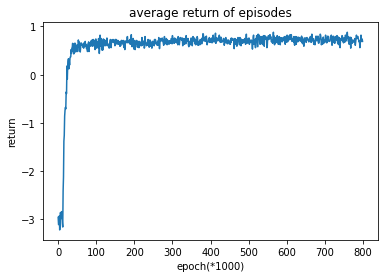

In [92]:
plt.plot(eval_rets)
plt.title('average return of episodes')
plt.ylabel('return')
plt.xlabel('epoch(*1000)')

In [95]:
eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='test',
    nhops=[1,2,3]
)

avg_ret1 = np.mean(evaluate_agent(eval_env, ddqn, k=1000))


eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='test',
    nhops=[1]
)

avg_ret2 = np.mean(evaluate_agent(eval_env, ddqn, k=1000))


eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='test',
    nhops=[2]
)

avg_ret3 = np.mean(evaluate_agent(eval_env, ddqn, k=1000))

eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='test',
    nhops=[3]
)

avg_ret4 = np.mean(evaluate_agent(eval_env, ddqn, k=10000))



Total env size in mode test: 39093
Total env size in mode test: 9947
Total env size in mode test: 14872
Total env size in mode test: 14274


In [97]:
avg_ret1, avg_ret2, avg_ret3, avg_ret4

(0.732, 0.921, 0.753, 0.5071)

Text(0.5, 1.0, 'accuracy of the agent in different settings on test dataset')

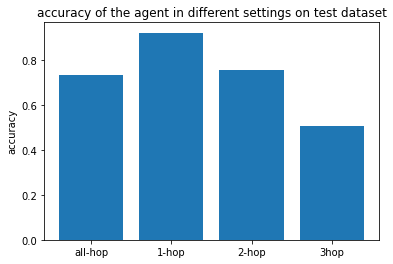

In [96]:
plt.bar(['all-hop', '1-hop', '2-hop', '3hop'], [avg_ret1, avg_ret2, avg_ret3, avg_ret4,])
plt.ylabel("accuracy")
plt.title('accuracy of the agent in different settings on test dataset')

In [106]:
def play_in_env(env, ddqn):
    state = env.reset()
    done = False
    
    while not done:
        env.render()        
        action = ddqn.get_action(state, det=True)
        print(f'action: {action}')
        state, reward, done, _ = env.step(action)
    print(f"reward: {reward}")
        
eval_env = KGEnv(
    len(relations_voc),
    observation_space=768+200+200+200,
    q_embeddings=question_embs,
    ent_embeddings=ent_emb_dict,
    rel_embeddings=rel_emb_dict,
    entities_vocab=entities_voc, 
    entities_inv_vocab=entities_inv_voc,
    rel_inv_voc=relations_inv_voc, rel_voc=relations_voc,
    mode='test',
    nhops=[3]
)
        
play_in_env(eval_env, ddqn)

Total env size in mode test: 14274
who starred films for the director of Our Town
current entity: Our Town
available moves:
--starred_actors(3)--> William Holden
--has_genre(10)--> Drama
--directed_by(0)--> Sam Wood
--starred_actors(3)--> Beulah Bondi
--release_year(2)--> 1940
--release_year(2)--> 2003
--written_by(12)--> Thornton Wilder
--starred_actors(3)--> Martha Scott
--starred_actors(3)--> Fay Bainter
--written_by(12)--> Frank Craven
--written_by(12)--> Harry Chandlee
action: 0
who starred films for the director of Our Town
current entity: Sam Wood
available moves:
--directed_by_reverse(9)--> For Whom the Bell Tolls
--directed_by_reverse(9)--> Saratoga Trunk
--directed_by_reverse(9)--> Kings Row
--directed_by_reverse(9)--> Our Town
--directed_by_reverse(9)--> Gone with the Wind
--directed_by_reverse(9)--> Goodbye, Mr. Chips
--directed_by_reverse(9)--> The Devil and Miss Jones
--directed_by_reverse(9)--> The Stratton Story
--directed_by_reverse(9)--> Casanova Brown
--directed_by_r